In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

import numpy as np
import seaborn as sns
import pandas as pd
import wandb

pd.set_option('display.max_columns', None)

In [2]:
api = wandb.Api()
entity, project = "invariance-learners", "icml2024"  # set to your entity and project 

In [3]:
# create dict mapping sweep name to sweep id
sweep_id_dict = {
    "gen_rand_dsprites_sweep_0": "08albiu0",
    "gen_rand_mnist_sweep_000_25k_0": "mgczupqy",
    "gen_rand_mnist_sweep_090_25k_0": "vydo5t3g",
    "gen_rand_mnist_sweep_180_25k_0": "4owwzwot",
    "gen_rand_mnist_sweep_000_37k5_0": "wpee7nu6",
    "gen_rand_mnist_sweep_090_37k5_0": "w2iyw5xx",
    "gen_rand_mnist_sweep_180_37k5_0": "vs53x69b",
    "gen_rand_mnist_sweep_000_50k_0": "x86jy66d",
    "gen_rand_mnist_sweep_090_50k_0": "2l197qsw",
    "gen_rand_mnist_sweep_180_50k_0": "igg8byqx",
}

In [4]:
summary_list, config_list, name_list, tags, ids, states, sweeps = [], [], [], [], [], [],  []

for sweep, sweep_id in sweep_id_dict.items():
    runs = api.sweep(entity + "/" + project + "/" + sweep_id).runs

    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

        tags.append(run.tags)

        ids.append(run.id)

        states.append(run.state)

        sweeps.append(sweep)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "tags": tags,
    "id": ids,
    "state": states,
    "sweep": sweeps,
    })

runs_df

,summary,config,name,tags,id,state,sweep
0,"{'valid/loss': -6.1291985511779785, 'gen_plots...","{'lr': 0.0034169872493605142, 'seed': 0, 'mode...",resilient-sweep-30,[],2vroxsqd,finished,gen_rand_dsprites_sweep_0
1,"{'inf_plots_12': {'size': 27834, '_type': 'ima...","{'lr': 0.0002487529248954416, 'seed': 0, 'mode...",upbeat-sweep-29,[],jzvr1ir4,finished,gen_rand_dsprites_sweep_0
2,"{'inf_plots_0': {'height': 300, 'sha256': '521...","{'lr': 0.00995908392150567, 'seed': 0, 'model'...",firm-sweep-32,[],qc1g9hiq,finished,gen_rand_dsprites_sweep_0
3,"{'_wandb': {'runtime': 592}, 'gen_plots_1': {'...","{'lr': 0.00731991441207847, 'seed': 0, 'model'...",upbeat-sweep-31,[],ug0v0ghc,finished,gen_rand_dsprites_sweep_0
4,"{'valid/mae': 0.7066983580589294, 'train/loss'...","{'lr': 0.00021919622776295217, 'seed': 0, 'mod...",proud-sweep-27,[],gwc0hkjr,finished,gen_rand_dsprites_sweep_0
...,...,...,...,...,...,...,...
315,{'inf_plots_0': {'path': 'media/images/inf_plo...,"{'lr': 0.0005037091727392963, 'seed': 0, 'angl...",smart-sweep-9,[],xsol9ene,finished,gen_rand_mnist_sweep_180_50k_0
316,{'gen_rep_plots_1': {'path': 'media/images/gen...,"{'lr': 0.0027706030397997667, 'seed': 0, 'angl...",vague-sweep-4,[],kg2loo5i,finished,gen_rand_mnist_sweep_180_50k_0
317,"{'lr_gen': 1.938278046509367e-06, '_timestamp'...","{'lr': 0.004033220142300389, 'seed': 0, 'angle...",twilight-sweep-2,[],kt2qq233,finished,gen_rand_mnist_sweep_180_50k_0
318,"{'inf_plots_1': {'size': 71701, '_type': 'imag...","{'lr': 0.00021012329713916456, 'seed': 0, 'ang...",twilight-sweep-3,[],5l0m6v2t,finished,gen_rand_mnist_sweep_180_50k_0


In [5]:
df_expanded = runs_df.join(pd.json_normalize(runs_df['summary'], record_prefix='summary.').add_prefix('summary.')).drop('summary', axis='columns')
df_expanded = df_expanded.join(pd.json_normalize(runs_df['config'], record_prefix='config').add_prefix('config.')).drop('config', axis='columns')

df_expanded.columns

Index(['name', 'tags', 'id', 'state', 'sweep', 'summary.valid/loss',
       'summary._step', 'summary.train/mae', 'summary._timestamp',
       'summary.train/loss',
       ...
       'config.aug_dsprites.ellipse_distribution.x_position',
       'config.aug_dsprites.ellipse_distribution.y_position',
       'config.aug_dsprites.ellipse_distribution.orientation',
       'config.aug_dsprites.ellipse_distribution.unnormalised_shape_prob',
       'config.angle', 'config.num_trn', 'config.num_val', 'config.shuffle',
       'config.shuffle_buffer_size', 'config.repeat_after_batching'],
      dtype='object', length=236)

In [117]:
# take only completed runs
df_filtered = df_expanded[df_expanded['state'] != 'failed']

# take only runs with certain tags
# tags_to_keep = ['angle_sweep', 'num_trn_sweep', 'mnist', 'vae']
# df_filtered = df_filtered[df_filtered['tags'].apply(lambda x: all(tag in x for tag in tags_to_keep))]

# take only runs without certain tags
# tags_to_remove = ['test', 'hidden', 'ssilvae']
# df_filtered = df_filtered[~df_filtered['tags'].apply(lambda x: any(tag in x for tag in tags_to_remove))]

# replace nans in config.num_trn and config.angle with -1
df_filtered['config.num_trn'] = df_filtered['config.num_trn'].fillna(-1)
df_filtered['config.angle'] = df_filtered['config.angle'].fillna(0)

df_filtered

,name,tags,id,state,sweep,summary.valid/loss,summary._step,summary.train/mae,summary._timestamp,summary.train/loss,summary.lr_gen,summary.grad_norm,summary.valid/mae,summary._runtime,summary.valid/log_p_η_x_hat,summary.mae_loss_mult,summary.train/log_p_η_x_hat,summary.gen_plots_1._type,summary.gen_plots_1.width,summary.gen_plots_1.format,summary.gen_plots_1.height,summary.gen_plots_1.sha256,summary.gen_plots_1.path,summary.gen_plots_1.size,summary.gen_plots_2.height,summary.gen_plots_2.sha256,summary.gen_plots_2.path,summary.gen_plots_2.size,summary.gen_plots_2._type,summary.gen_plots_2.width,summary.gen_plots_2.format,summary.inf_plots_13.width,summary.inf_plots_13.format,summary.inf_plots_13.height,summary.inf_plots_13.sha256,summary.inf_plots_13.path,summary.inf_plots_13.size,summary.inf_plots_13._type,summary.inf_plots_14.size,summary.inf_plots_14._type,summary.inf_plots_14.width,summary.inf_plots_14.format,summary.inf_plots_14.height,summary.inf_plots_14.sha256,summary.inf_plots_14.path,summary.inf_plots_1.size,summary.inf_plots_1._type,summary.inf_plots_1.width,summary.inf_plots_1.format,summary.inf_plots_1.height,summary.inf_plots_1.sha256,summary.inf_plots_1.path,summary.inf_plots_7.height,summary.inf_plots_7.sha256,summary.inf_plots_7.path,summary.inf_plots_7.size,summary.inf_plots_7._type,summary.inf_plots_7.width,summary.inf_plots_7.format,summary.gen_rep_plots_2._type,summary.gen_rep_plots_2.width,summary.gen_rep_plots_2.format,summary.gen_rep_plots_2.height,summary.gen_rep_plots_2.sha256,summary.gen_rep_plots_2.path,summary.gen_rep_plots_2.size,summary.gen_plots_3.size,summary.gen_plots_3._type,summary.gen_plots_3.width,summary.gen_plots_3.format,summary.gen_plots_3.height,summary.gen_plots_3.sha256,summary.gen_plots_3.path,summary.inf_plots_0.path,summary.inf_plots_0.size,summary.inf_plots_0._type,summary.inf_plots_0.width,summary.inf_plots_0.format,summary.inf_plots_0.height,summary.inf_plots_0.sha256,summary.gen_training_metrics.format,summary.gen_training_metrics.height,summary.gen_training_metrics.sha256,summary.gen_training_metrics.path,summary.gen_training_metrics.size,summary.gen_training_metrics._type,summary.gen_training_metrics.width,summary.inf_plots_4.sha256,summary.inf_plots_4.path,summary.inf_plots_4.size,summary.inf_plots_4._type,summary.inf_plots_4.width,summary.inf_plots_4.format,summary.inf_plots_4.height,summary.inf_plots_11.size,summary.inf_plots_11._type,summary.inf_plots_11.width,summary.inf_plots_11.format,summary.inf_plots_11.height,summary.inf_plots_11.sha256,summary.inf_plots_11.path,summary._wandb.runtime,summary.inf_plots_2.height,summary.inf_plots_2.sha256,summary.inf_plots_2.path,summary.inf_plots_2.size,summary.inf_plots_2._type,summary.inf_plots_2.width,summary.inf_plots_2.format,summary.inf_plots_9._type,summary.inf_plots_9.width,summary.inf_plots_9.format,summary.inf_plots_9.height,summary.inf_plots_9.sha256,summary.inf_plots_9.path,summary.inf_plots_9.size,summary.inf_plots_10.path,summary.inf_plots_10.size,summary.inf_plots_10._type,summary.inf_plots_10.width,summary.inf_plots_10.format,summary.inf_plots_10.height,summary.inf_plots_10.sha256,summary.gen_rep_plots_1.path,summary.gen_rep_plots_1.size,summary.gen_rep_plots_1._type,summary.gen_rep_plots_1.width,summary.gen_rep_plots_1.format,summary.gen_rep_plots_1.height,summary.gen_rep_plots_1.sha256,summary.inf_plots_5.format,summary.inf_plots_5.height,summary.inf_plots_5.sha256,summary.inf_plots_5.path,summary.inf_plots_5.size,summary.inf_plots_5._type,summary.inf_plots_5.width,summary.inf_plots_8.size,summary.inf_plots_8._type,summary.inf_plots_8.width,summary.inf_plots_8.format,summary.inf_plots_8.height,summary.inf_plots_8.sha256,summary.inf_plots_8.path,summary.gen_plots_0.height,summary.gen_plots_0.sha256,summary.gen_plots_0.path,summary.gen_plots_0.size,summary.gen_plots_0._type,summary.gen_plots_0.width,summary.gen_plots_0.format,summary.gen_plots_4.sha256,summary.gen_plots_4.path,summary.gen_plots_4.size,summary.gen_plo

In [118]:
df_filtered['config.angle'].unique()

array([  0.,  90., 180.])

In [119]:
df_filtered['config.steps'].unique()

array([30000, 60000, 15000])

In [120]:
df_filtered['config.num_trn'].unique()

array([-1.00e+00,  2.50e+04,  3.75e+04,  5.00e+04])

In [121]:
df_filtered['config.dataset'].unique()

array(['aug_dsprites', 'MNIST'], dtype=object)

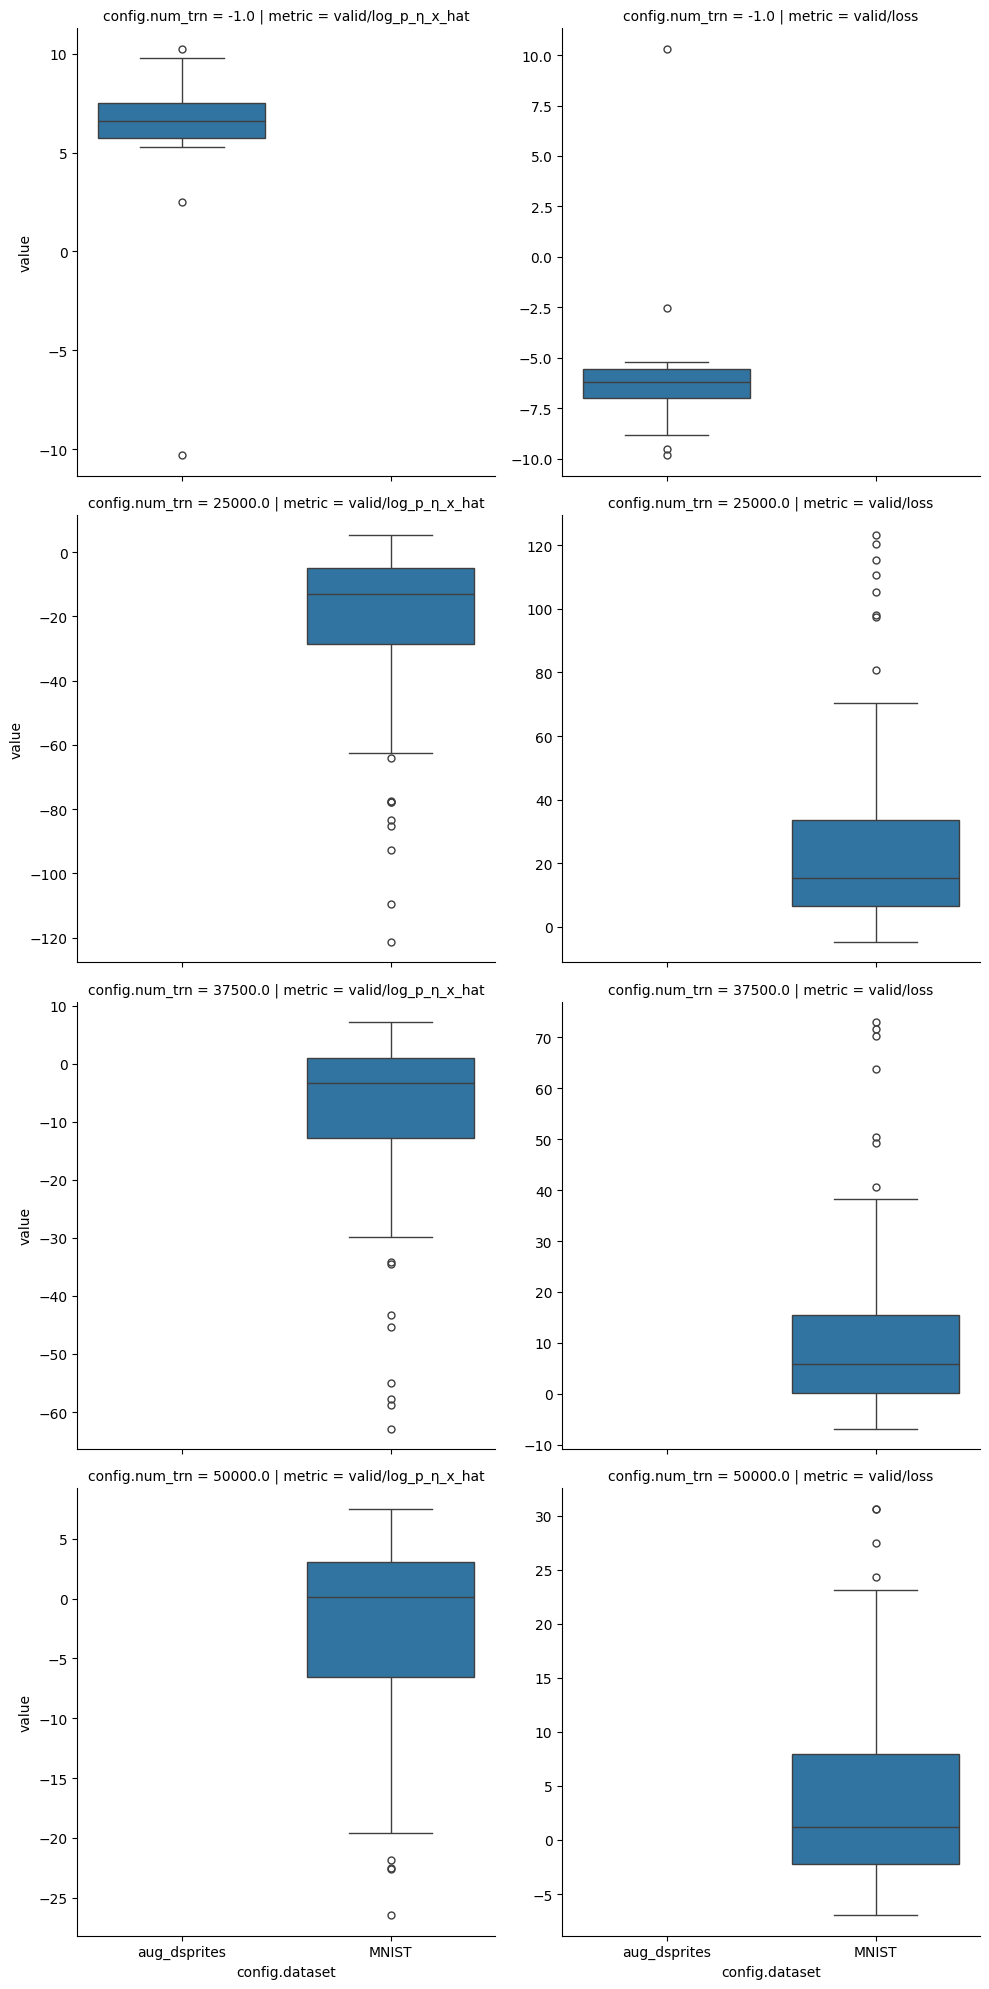

In [122]:
plot_df = df_filtered[[
    'summary.valid/log_p_η_x_hat', 'summary.valid/loss', 'config.angle',  'config.num_trn', 'config.dataset'
]]

# take only some settings
# plot_df = plot_df[
#     plot_df['config.init_lr'].isin([0.0003])
# ]

# pivot the data frame so that each of metrics is a column, and the values are the corresponding values
plot_df = plot_df.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.dataset'],
    value_vars=['summary.valid/log_p_η_x_hat', 'summary.valid/loss'],
    var_name='metric',
    value_name='value'
)

# remove the 'summary.' prefix from the metric names
plot_df['metric'] = plot_df['metric'].str.replace('summary.', '')


sns.catplot(data=plot_df, x="config.dataset", y="value", col="metric", row='config.num_trn', kind="box", showfliers=True, sharey=False)

In [123]:
hyper_names = ['config.' + x for x in [
    'clip_norm', 'final_lr_mult', 'init_lr_mult', 'lr', 'mae_loss_mult_final', 'mae_loss_mult_initial',
    'model.conditioner.hidden_dims', 'model.hidden_dims', 'model.num_bins', 'model.num_flows',
    'model.squash_to_bounds', 'model.use_layernorm', 'n_samples', 'steps', 'warmup_steps_pct',
    'weight_decay'
]]

In [124]:
df_filtered['config.n_samples'] = df_filtered['config.n_samples'].astype(str)
df_filtered['config.steps'] = df_filtered['config.steps'].astype(str)
df_filtered['config.model.num_flows'] = df_filtered['config.model.num_flows'].astype(str)
df_filtered['config.model.num_bins'] = df_filtered['config.model.num_bins'].astype(str)

In [128]:
# filter out outliers based on log_p_η_x_hat.
# For MNIST with 50K training samples: < -20
# For MNIST with 37.5K training samples: < -30
# For MNIST with 25K training samples: < -60
# For dSprites: < 5

dsprites_rule = (df_filtered['config.dataset'] == 'aug_dsprites') & (df_filtered['summary.valid/log_p_η_x_hat'] < 5)
mnist_50k_rule = (df_filtered['config.dataset'] == 'MNIST') & (df_filtered['config.num_trn'] == 50000) & (df_filtered['summary.valid/log_p_η_x_hat'] < -20)
mnist_37k5_rule = (df_filtered['config.dataset'] == 'MNIST') & (df_filtered['config.num_trn'] == 37500) & (df_filtered['summary.valid/log_p_η_x_hat'] < -30)
mnist_25k_rule = (df_filtered['config.dataset'] == 'MNIST') & (df_filtered['config.num_trn'] == 25000) & (df_filtered['summary.valid/log_p_η_x_hat'] < -60)

df_filtered = df_filtered[~(dsprites_rule | mnist_50k_rule | mnist_37k5_rule | mnist_25k_rule)]
df_filtered

,name,tags,id,state,sweep,summary.valid/loss,summary._step,summary.train/mae,summary._timestamp,summary.train/loss,summary.lr_gen,summary.grad_norm,summary.valid/mae,summary._runtime,summary.valid/log_p_η_x_hat,summary.mae_loss_mult,summary.train/log_p_η_x_hat,summary.gen_plots_1._type,summary.gen_plots_1.width,summary.gen_plots_1.format,summary.gen_plots_1.height,summary.gen_plots_1.sha256,summary.gen_plots_1.path,summary.gen_plots_1.size,summary.gen_plots_2.height,summary.gen_plots_2.sha256,summary.gen_plots_2.path,summary.gen_plots_2.size,summary.gen_plots_2._type,summary.gen_plots_2.width,summary.gen_plots_2.format,summary.inf_plots_13.width,summary.inf_plots_13.format,summary.inf_plots_13.height,summary.inf_plots_13.sha256,summary.inf_plots_13.path,summary.inf_plots_13.size,summary.inf_plots_13._type,summary.inf_plots_14.size,summary.inf_plots_14._type,summary.inf_plots_14.width,summary.inf_plots_14.format,summary.inf_plots_14.height,summary.inf_plots_14.sha256,summary.inf_plots_14.path,summary.inf_plots_1.size,summary.inf_plots_1._type,summary.inf_plots_1.width,summary.inf_plots_1.format,summary.inf_plots_1.height,summary.inf_plots_1.sha256,summary.inf_plots_1.path,summary.inf_plots_7.height,summary.inf_plots_7.sha256,summary.inf_plots_7.path,summary.inf_plots_7.size,summary.inf_plots_7._type,summary.inf_plots_7.width,summary.inf_plots_7.format,summary.gen_rep_plots_2._type,summary.gen_rep_plots_2.width,summary.gen_rep_plots_2.format,summary.gen_rep_plots_2.height,summary.gen_rep_plots_2.sha256,summary.gen_rep_plots_2.path,summary.gen_rep_plots_2.size,summary.gen_plots_3.size,summary.gen_plots_3._type,summary.gen_plots_3.width,summary.gen_plots_3.format,summary.gen_plots_3.height,summary.gen_plots_3.sha256,summary.gen_plots_3.path,summary.inf_plots_0.path,summary.inf_plots_0.size,summary.inf_plots_0._type,summary.inf_plots_0.width,summary.inf_plots_0.format,summary.inf_plots_0.height,summary.inf_plots_0.sha256,summary.gen_training_metrics.format,summary.gen_training_metrics.height,summary.gen_training_metrics.sha256,summary.gen_training_metrics.path,summary.gen_training_metrics.size,summary.gen_training_metrics._type,summary.gen_training_metrics.width,summary.inf_plots_4.sha256,summary.inf_plots_4.path,summary.inf_plots_4.size,summary.inf_plots_4._type,summary.inf_plots_4.width,summary.inf_plots_4.format,summary.inf_plots_4.height,summary.inf_plots_11.size,summary.inf_plots_11._type,summary.inf_plots_11.width,summary.inf_plots_11.format,summary.inf_plots_11.height,summary.inf_plots_11.sha256,summary.inf_plots_11.path,summary._wandb.runtime,summary.inf_plots_2.height,summary.inf_plots_2.sha256,summary.inf_plots_2.path,summary.inf_plots_2.size,summary.inf_plots_2._type,summary.inf_plots_2.width,summary.inf_plots_2.format,summary.inf_plots_9._type,summary.inf_plots_9.width,summary.inf_plots_9.format,summary.inf_plots_9.height,summary.inf_plots_9.sha256,summary.inf_plots_9.path,summary.inf_plots_9.size,summary.inf_plots_10.path,summary.inf_plots_10.size,summary.inf_plots_10._type,summary.inf_plots_10.width,summary.inf_plots_10.format,summary.inf_plots_10.height,summary.inf_plots_10.sha256,summary.gen_rep_plots_1.path,summary.gen_rep_plots_1.size,summary.gen_rep_plots_1._type,summary.gen_rep_plots_1.width,summary.gen_rep_plots_1.format,summary.gen_rep_plots_1.height,summary.gen_rep_plots_1.sha256,summary.inf_plots_5.format,summary.inf_plots_5.height,summary.inf_plots_5.sha256,summary.inf_plots_5.path,summary.inf_plots_5.size,summary.inf_plots_5._type,summary.inf_plots_5.width,summary.inf_plots_8.size,summary.inf_plots_8._type,summary.inf_plots_8.width,summary.inf_plots_8.format,summary.inf_plots_8.height,summary.inf_plots_8.sha256,summary.inf_plots_8.path,summary.gen_plots_0.height,summary.gen_plots_0.sha256,summary.gen_plots_0.path,summary.gen_plots_0.size,summary.gen_plots_0._type,summary.gen_plots_0.width,summary.gen_plots_0.format,summary.gen_plots_4.sha256,summary.gen_plots_4.path,summary.gen_plots_4.size,summary.gen_plo

## Analize sweeps

In [133]:
# pivot the data frame so that each of 'summary.valid/x_mse', 'summary.valid/loss', 'summary.valid/label_paired_image_mse'
# is a column, and the values are the corresponding values
df = df_filtered.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.dataset'] + hyper_names,
    value_vars=['summary.valid/log_p_η_x_hat', 'summary.valid/loss', 'summary.valid/mae'],
    var_name='metric',
    value_name='value'
)

df

,config.angle,config.num_trn,config.dataset,config.clip_norm,config.final_lr_mult,config.init_lr_mult,config.lr,config.mae_loss_mult_final,config.mae_loss_mult_initial,config.model.conditioner.hidden_dims,config.model.hidden_dims,config.model.num_bins,config.model.num_flows,config.model.squash_to_bounds,config.model.use_layernorm,config.n_samples,config.steps,config.warmup_steps_pct,config.weight_decay,metric,value
0,0.0,-1.0,aug_dsprites,11.956679,0.532332,0.197313,0.003417,0.613241,0.368508,"256,256","1024,512,128",4,6,True,True,5,30000,0.257579,0.000506,summary.valid/log_p_η_x_hat,6.442514
1,0.0,-1.0,aug_dsprites,2.167612,0.105915,0.295567,0.000249,0.503630,0.911395,"256,256","1024,512,256",6,4,False,False,2,60000,0.277109,0.000514,summary.valid/log_p_η_x_hat,10.256928
2,0.0,-1.0,aug_dsprites,1.980310,0.082177,0.265403,0.009959,0.787409,0.335707,"256,256","1024,512,256",4,6,False,False,3,15000,0.190005,0.000090,summary.valid/log_p_η_x_hat,NaN
3,0.0,-1.0,aug_dsprites,2.462416,0.000177,0.053849,0.007320,0.532605,0.474301,256,"1024,512,128",8,2,False,False,2,60000,0.070822,0.000570,summary.valid/log_p_η_x_hat,NaN
4,0.0,-1.0,aug_dsprites,49.844475,0.010685,0.670185,0.000219,0.330708,0.711272,256,"2048,512,256",6,2,True,True,2,15000,0.090003,0.000041,summary.valid/log_p_η_x_hat,5.418348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,180.0,50000.0,MNIST,33.266300,0.000137,0.019880,0.000504,0.301847,0.375999,"256,256","1024,512,256",4,6,True,False,2,30000,0.154625,0.000188,summary.valid/mae,3.923819
884,180.0,50000.0,MNIST,10.433644,0.272218,0.396481,0.002771,0.088121,0.747131,"256,256,256","1024,512,128",4,4,True,True,5,60000,0.241939,0.000123,summary.valid/mae,7.958104
885,180.0,50000.0,MNIST,28.303424,0.000481,0.011345,0.004033,0.522728,0.177796,256,"2048,512,256",4,4,True,True,2,30000,0.097201,0.000310,summary.valid/mae,2.212928
886,180.0,50000.0,MNIST,12.020790,0.005779,0.757522,0.000210,0.785858,0.574637,"256,256","1024,512,128",6,2,False,False,5,60000,0.029481,0.000169,summary.valid/mae,3.583339


In [134]:
METRIC = 'summary.valid/log_p_η_x_hat'

In [135]:
hyper_names

['config.clip_norm',
 'config.final_lr_mult',
 'config.init_lr_mult',
 'config.lr',
 'config.mae_loss_mult_final',
 'config.mae_loss_mult_initial',
 'config.model.conditioner.hidden_dims',
 'config.model.hidden_dims',
 'config.model.num_bins',
 'config.model.num_flows',
 'config.model.squash_to_bounds',
 'config.model.use_layernorm',
 'config.n_samples',
 'config.steps',
 'config.warmup_steps_pct',
 'config.weight_decay']

### clip_norm

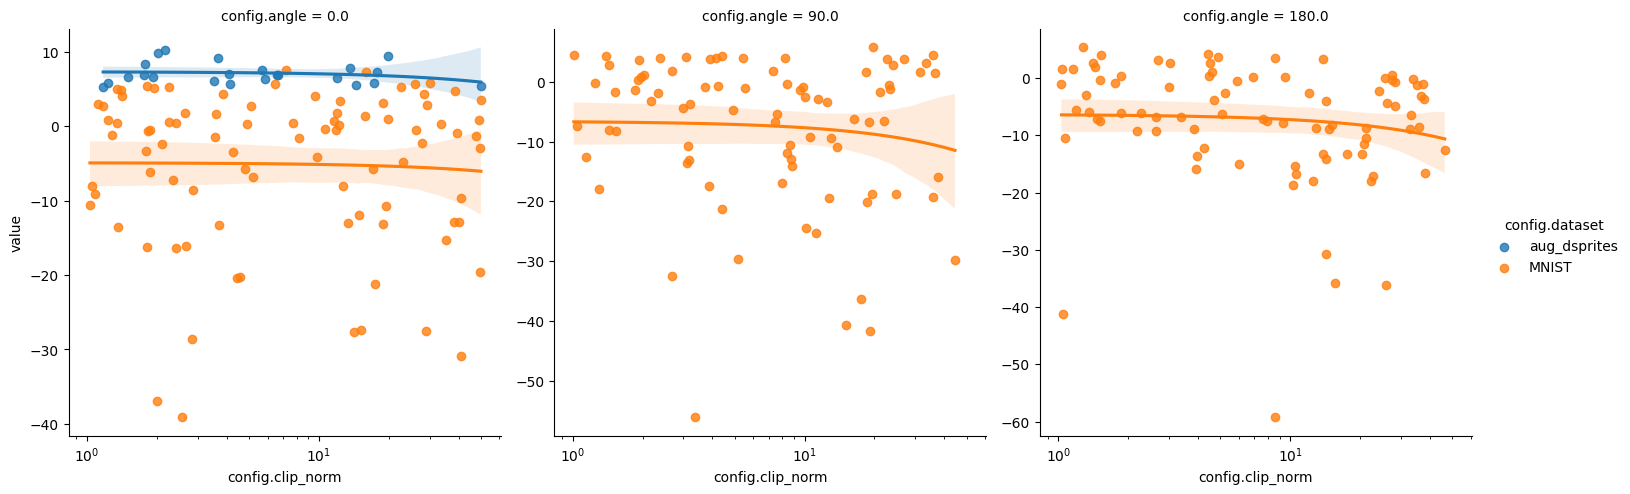

In [136]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.clip_norm",
    y="value",
    col="config.angle",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

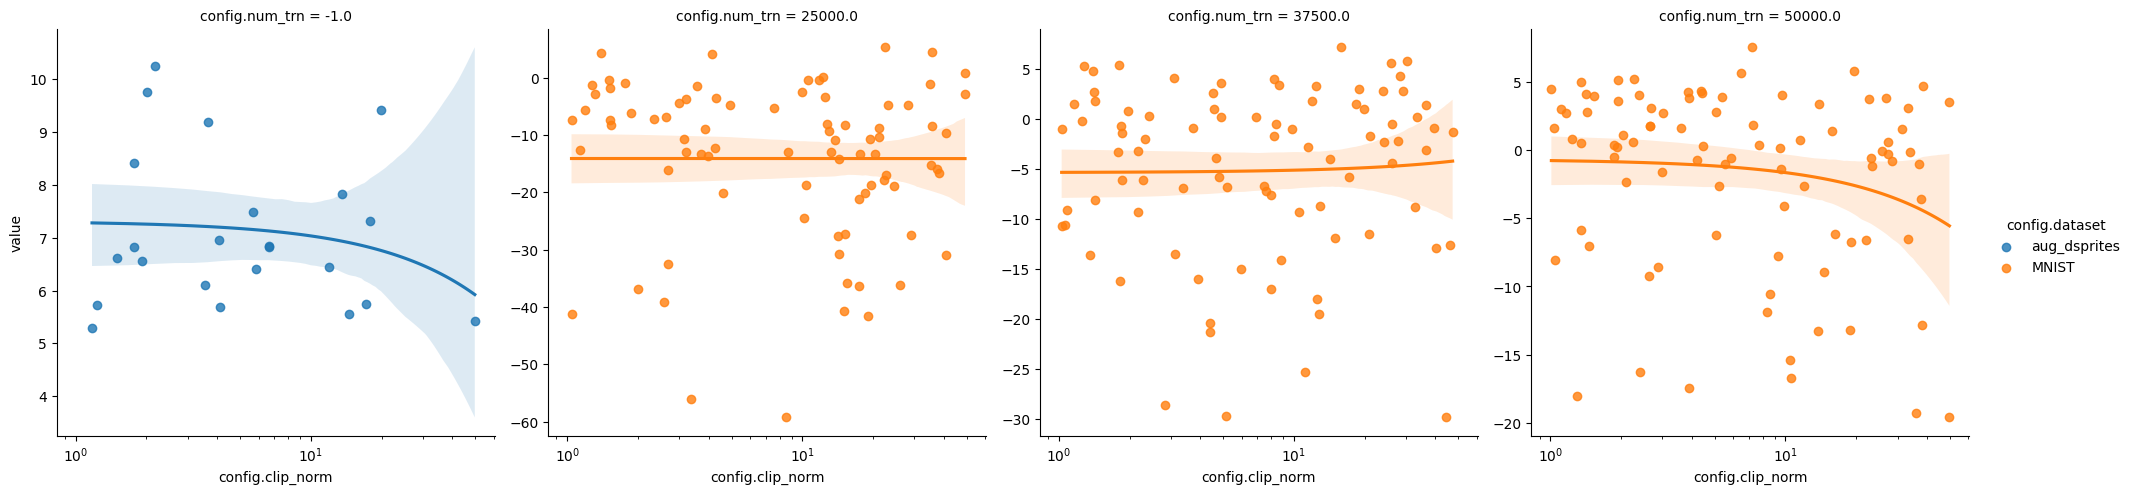

In [137]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.clip_norm",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

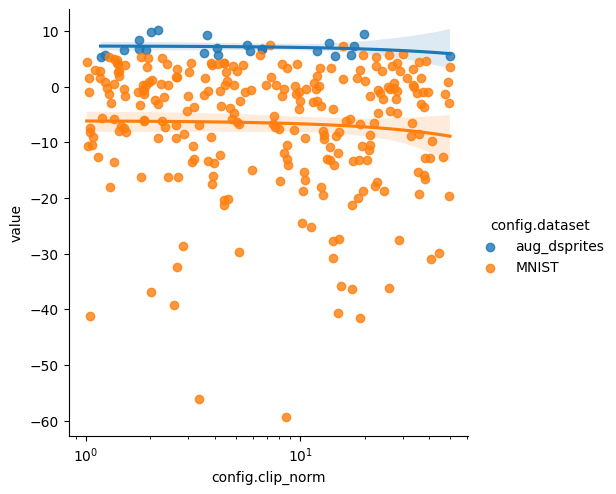

In [138]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.clip_norm",
    y="value",
    hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

### final_lr_mult

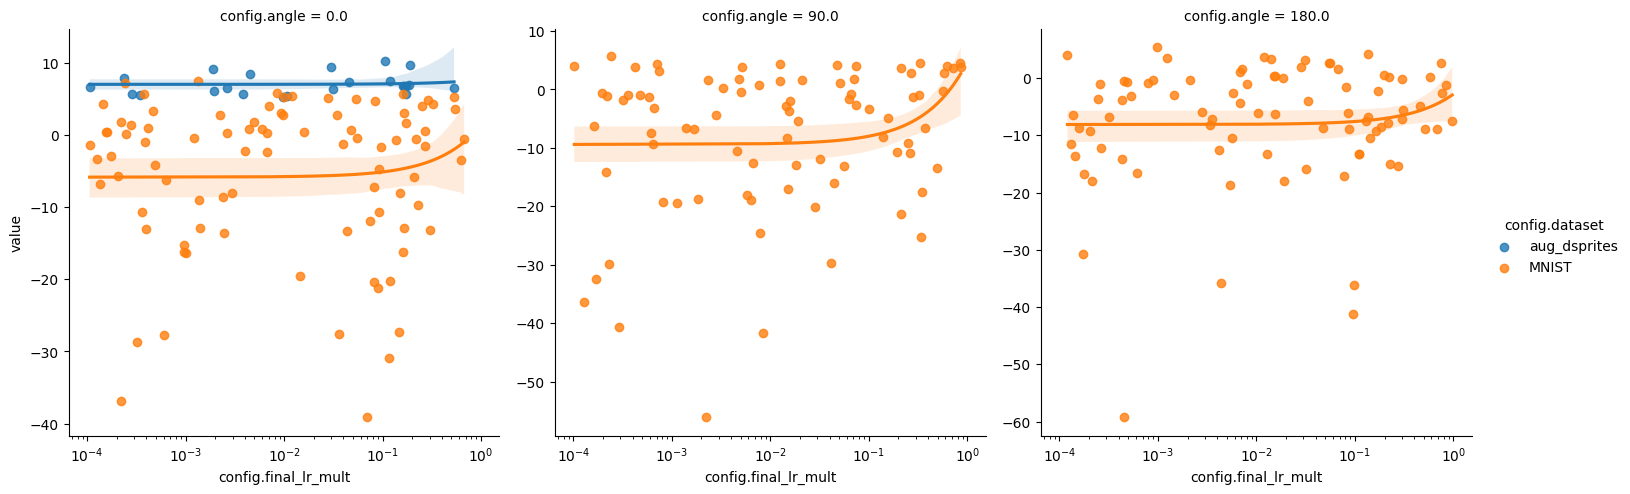

In [139]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.final_lr_mult",
    y="value",
    col="config.angle",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

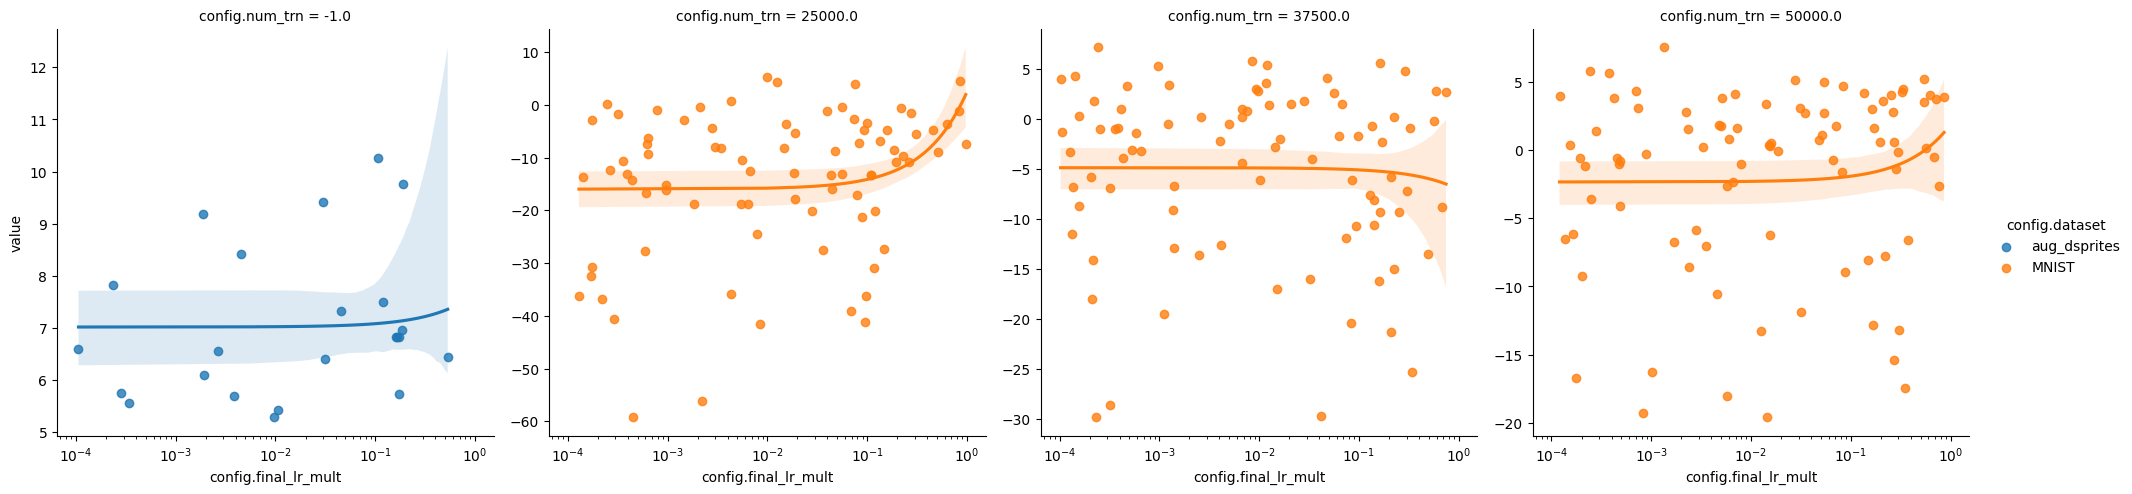

In [140]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.final_lr_mult",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

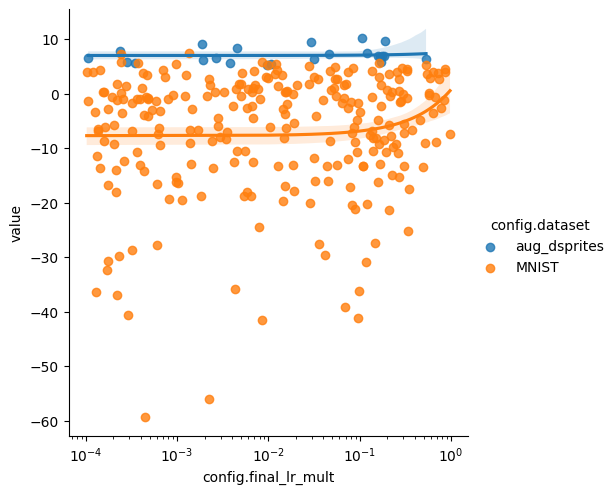

In [141]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.final_lr_mult",
    y="value",
    hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

### init_lr_mult

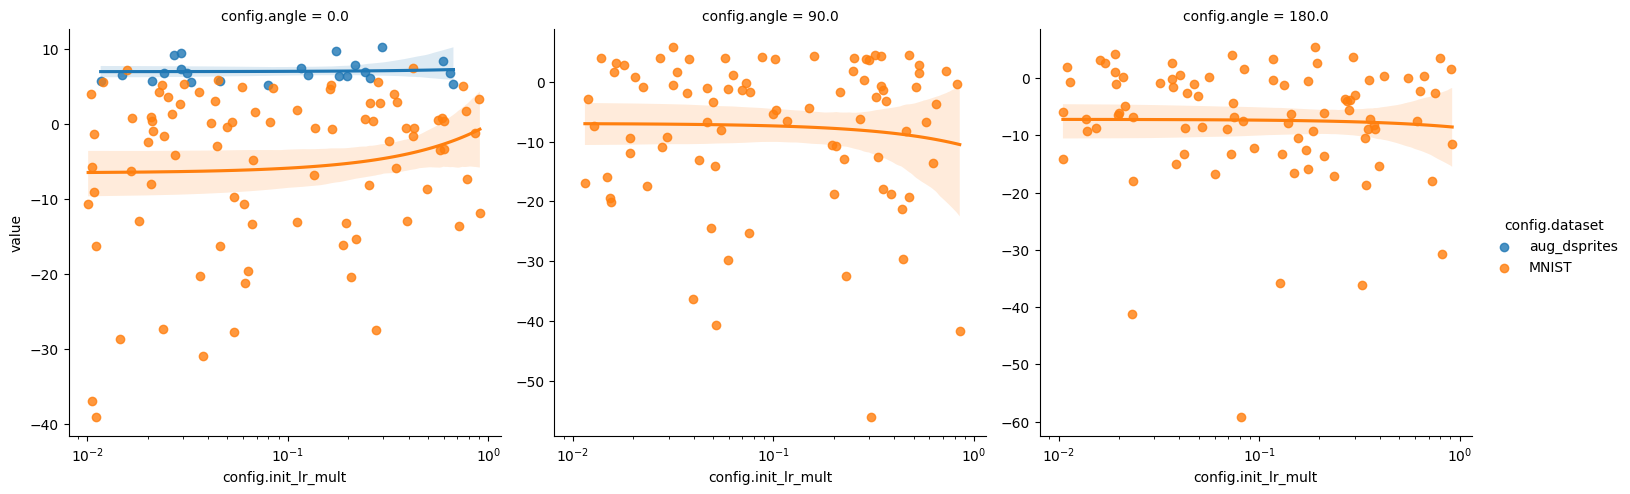

In [142]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.init_lr_mult",
    y="value",
    col="config.angle",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

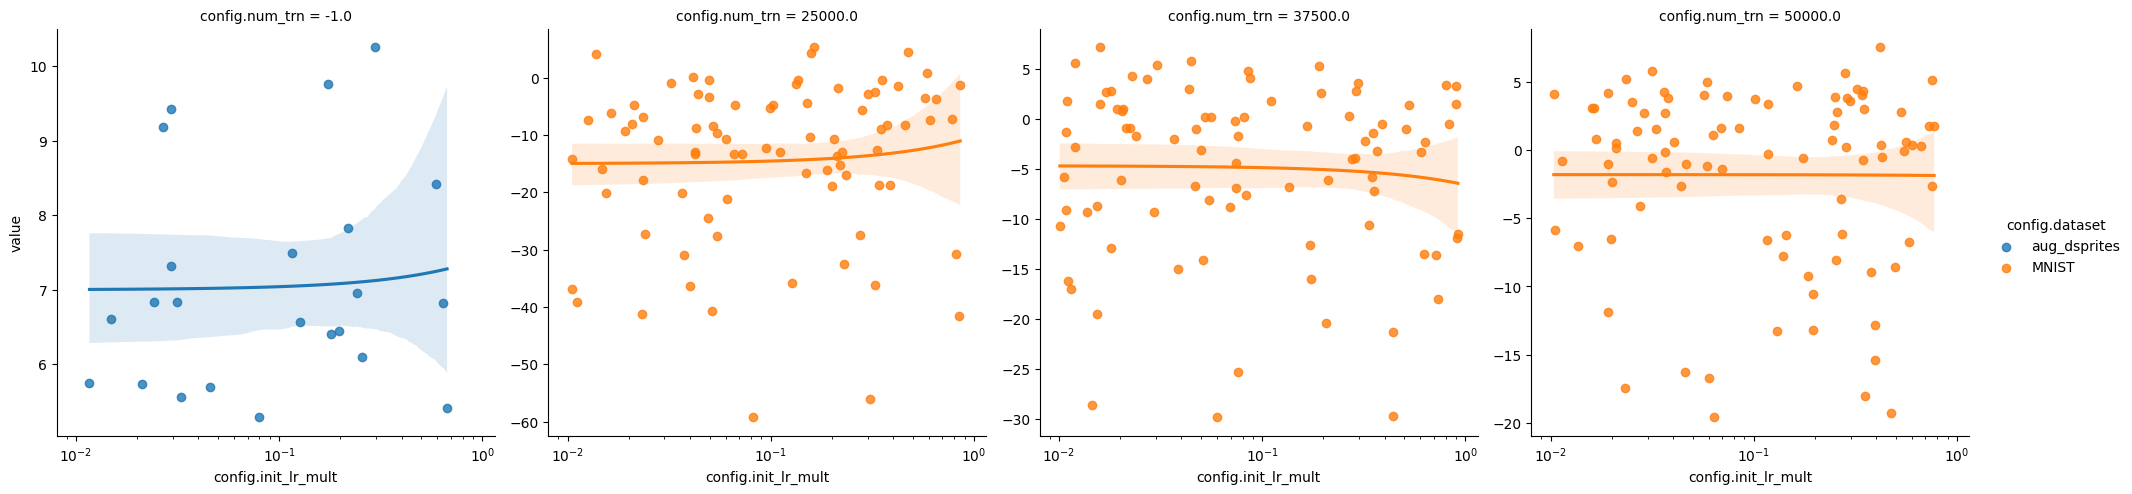

In [143]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.init_lr_mult",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

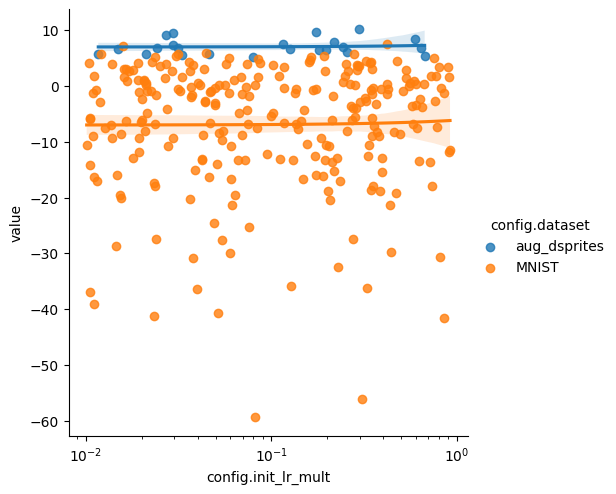

In [144]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.init_lr_mult",
    y="value",
    hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

### lr

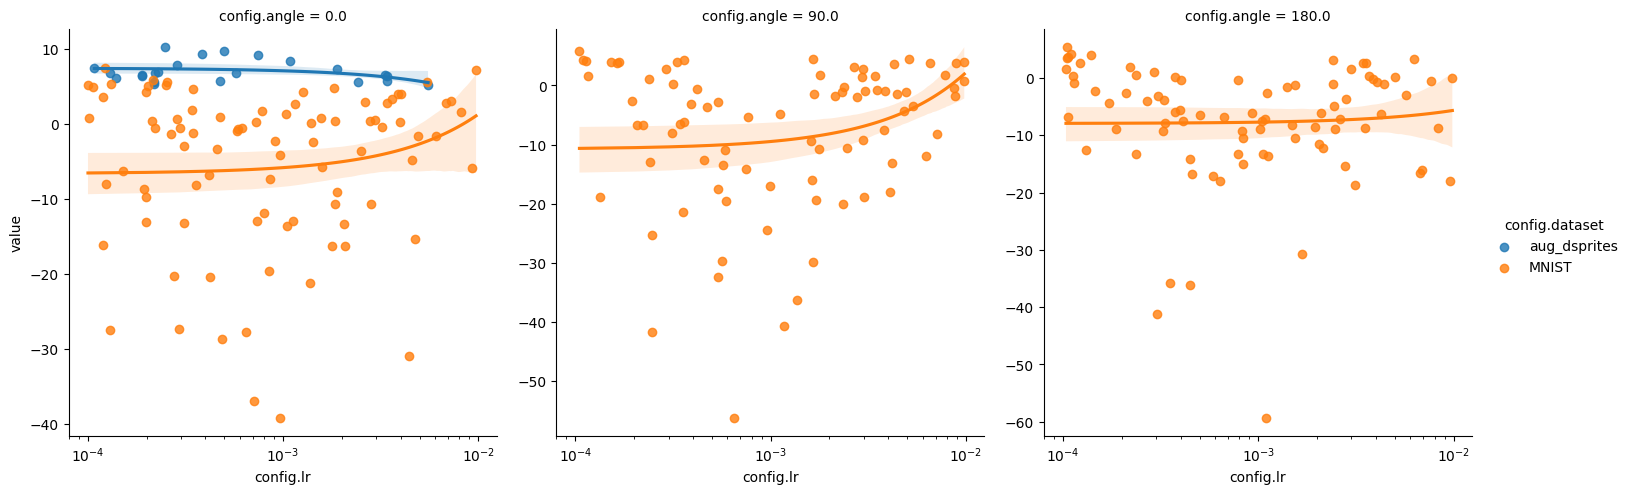

In [145]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.lr",
    y="value",
    col="config.angle",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

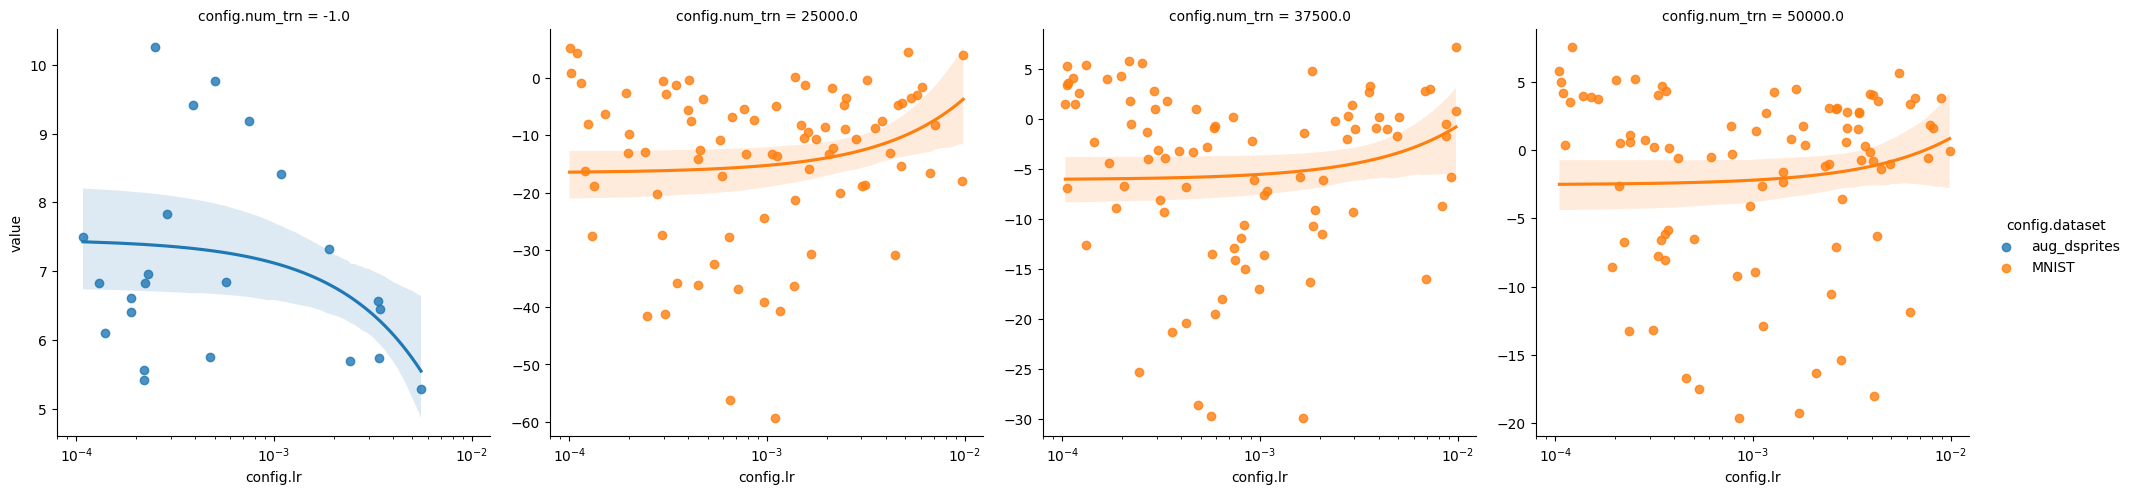

In [146]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.lr",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

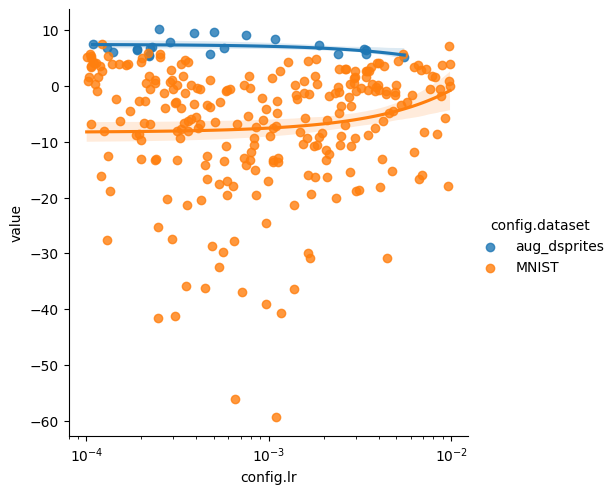

In [147]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.lr",
    y="value",
    hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

### mae_loss_mult_final

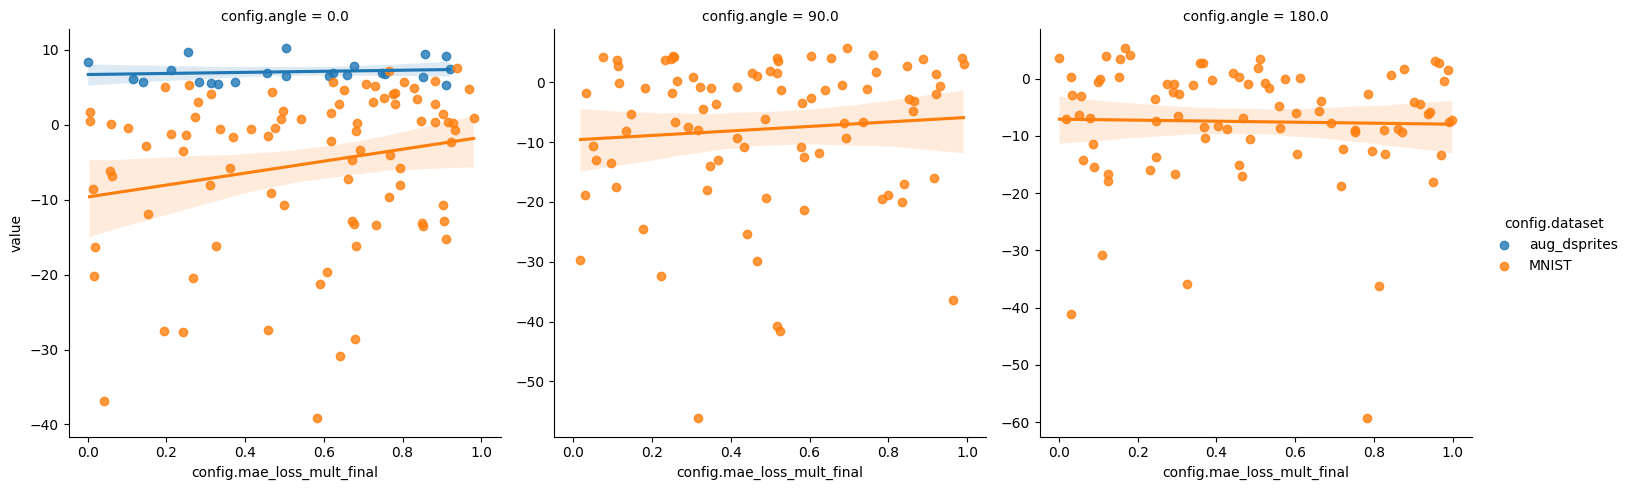

In [148]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_final",
    y="value",
    col="config.angle",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

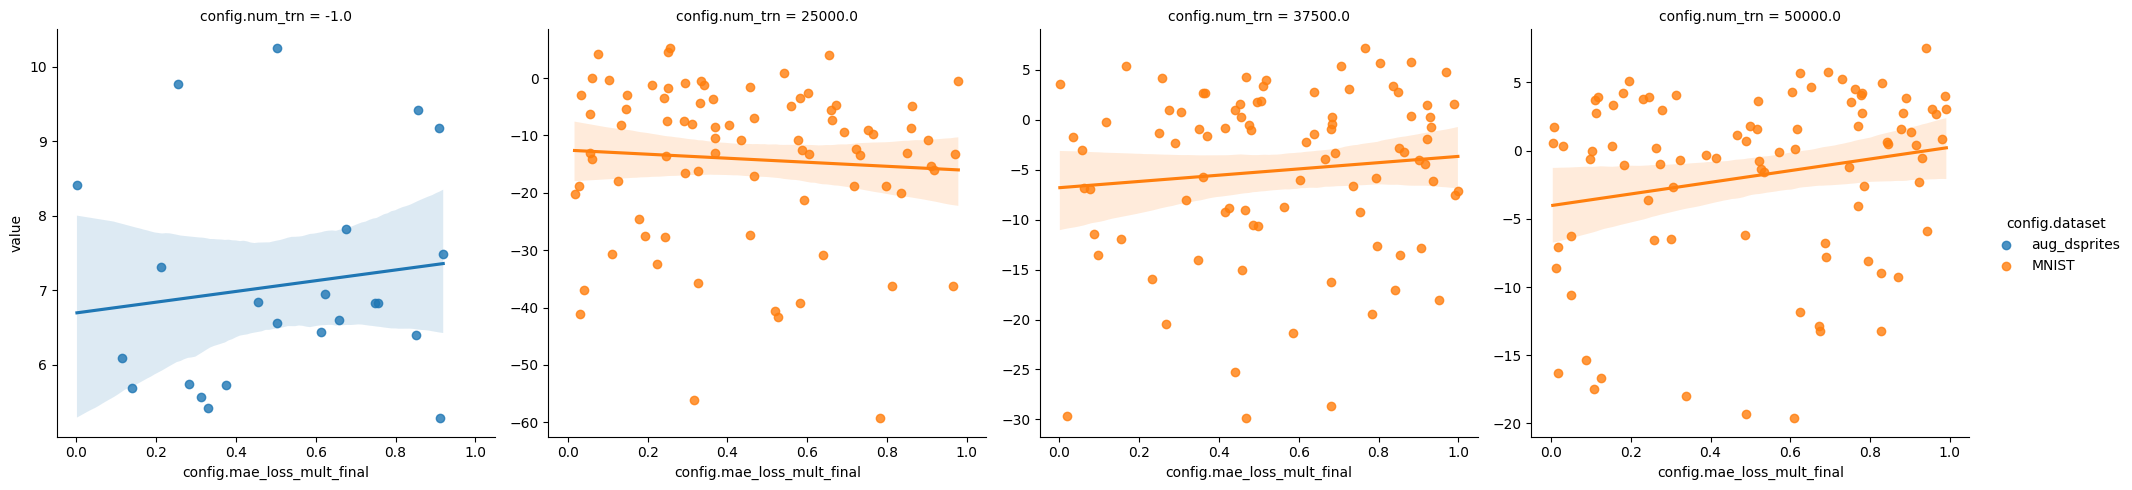

In [149]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_final",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

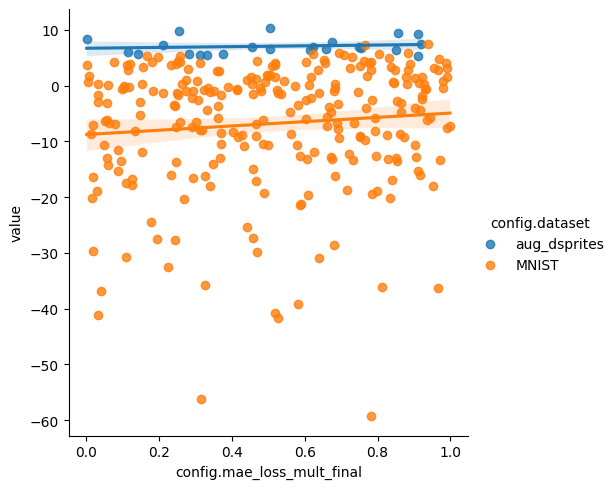

In [150]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_final",
    y="value",
    hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

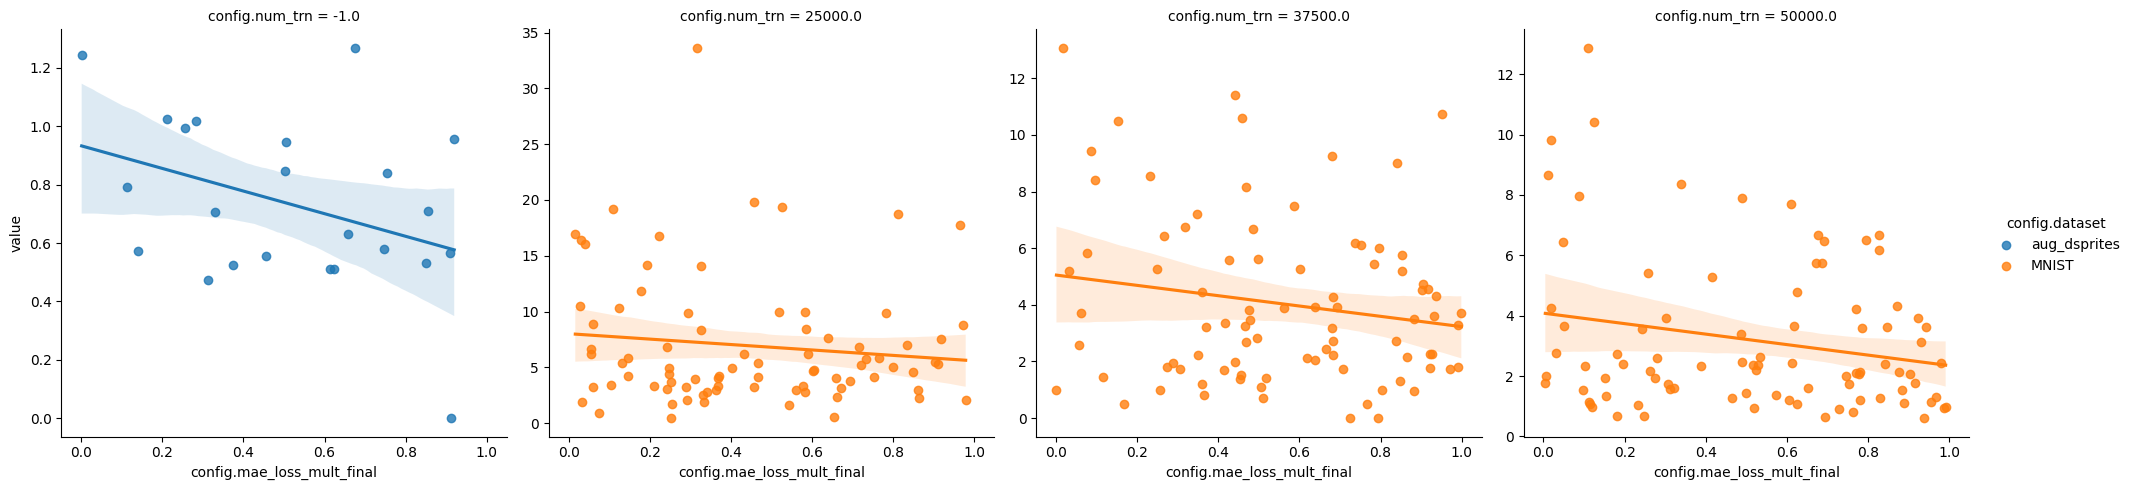

In [186]:
g = sns.lmplot(
    data=df[df.metric == "summary.valid/mae"],
    x="config.mae_loss_mult_final",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

### mae_loss_mult_initial

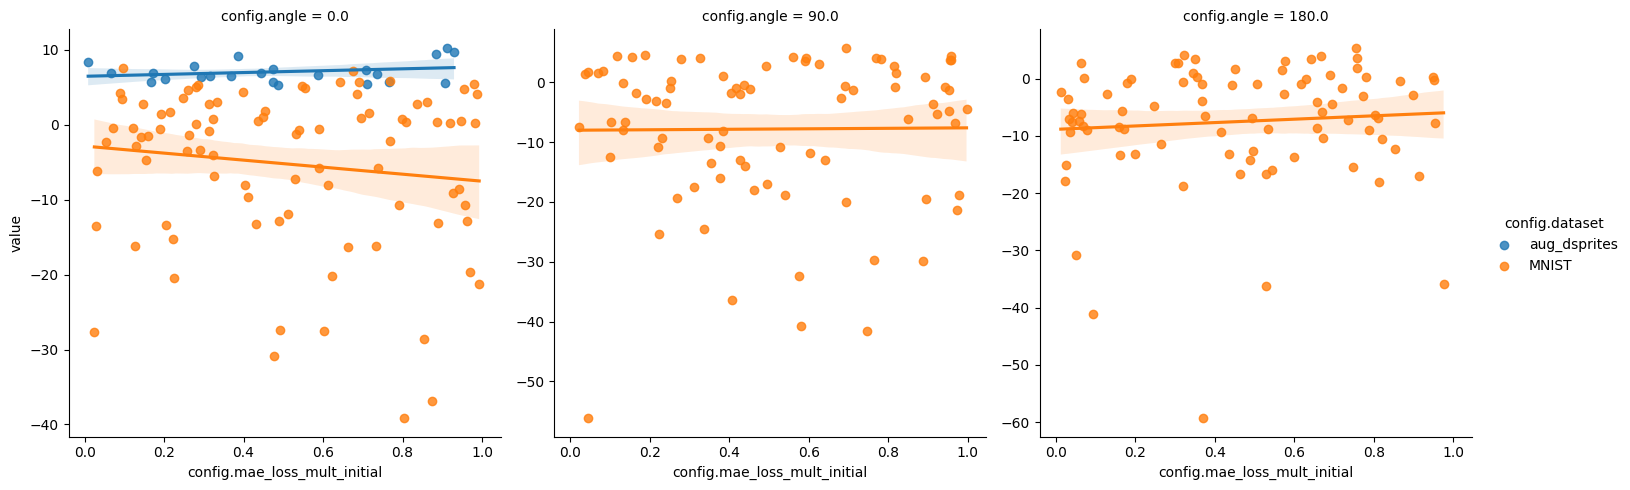

In [151]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_initial",
    y="value",
    col="config.angle",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

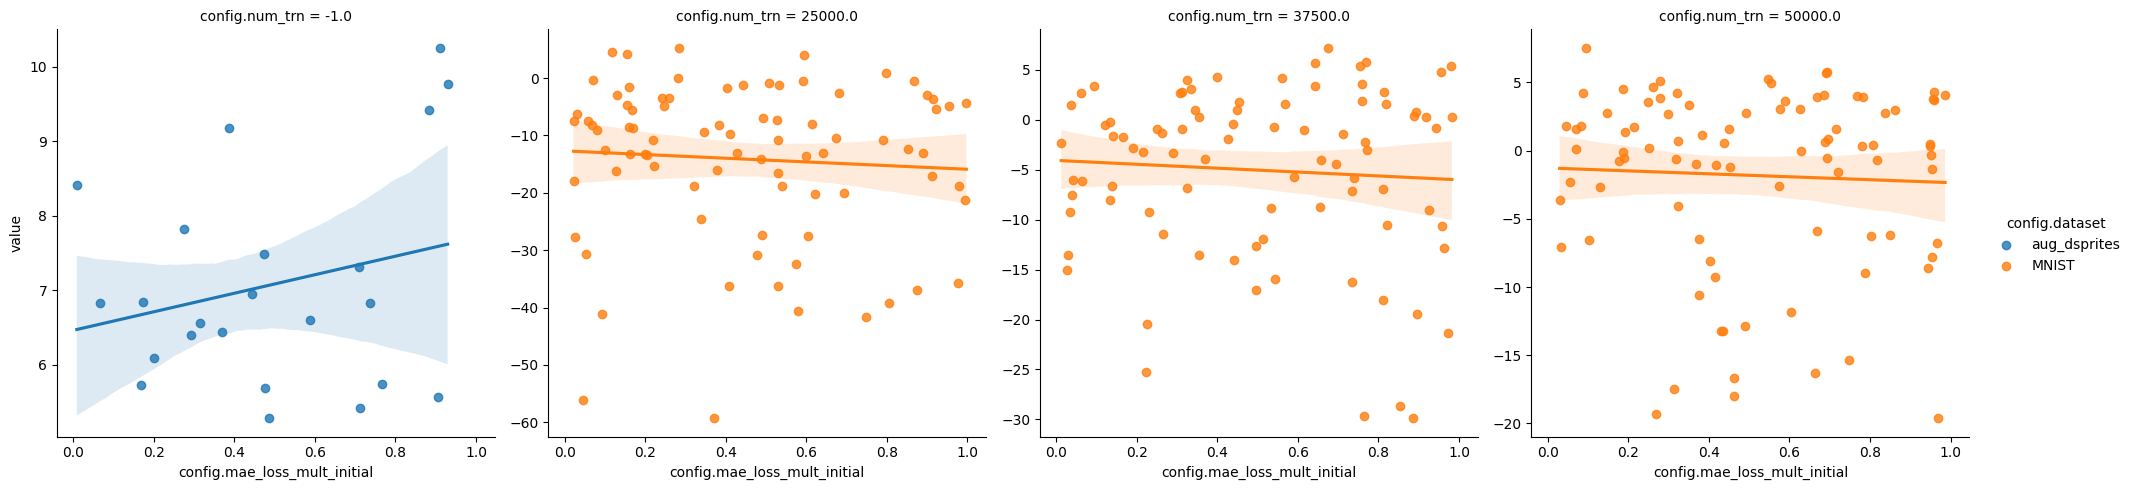

In [152]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_initial",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

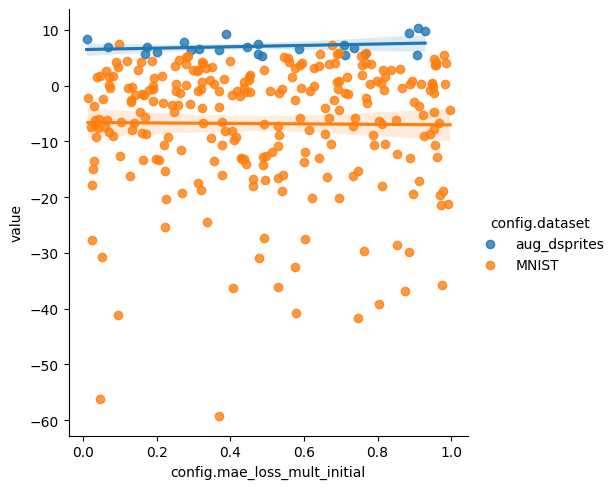

In [153]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_initial",
    y="value",
    hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

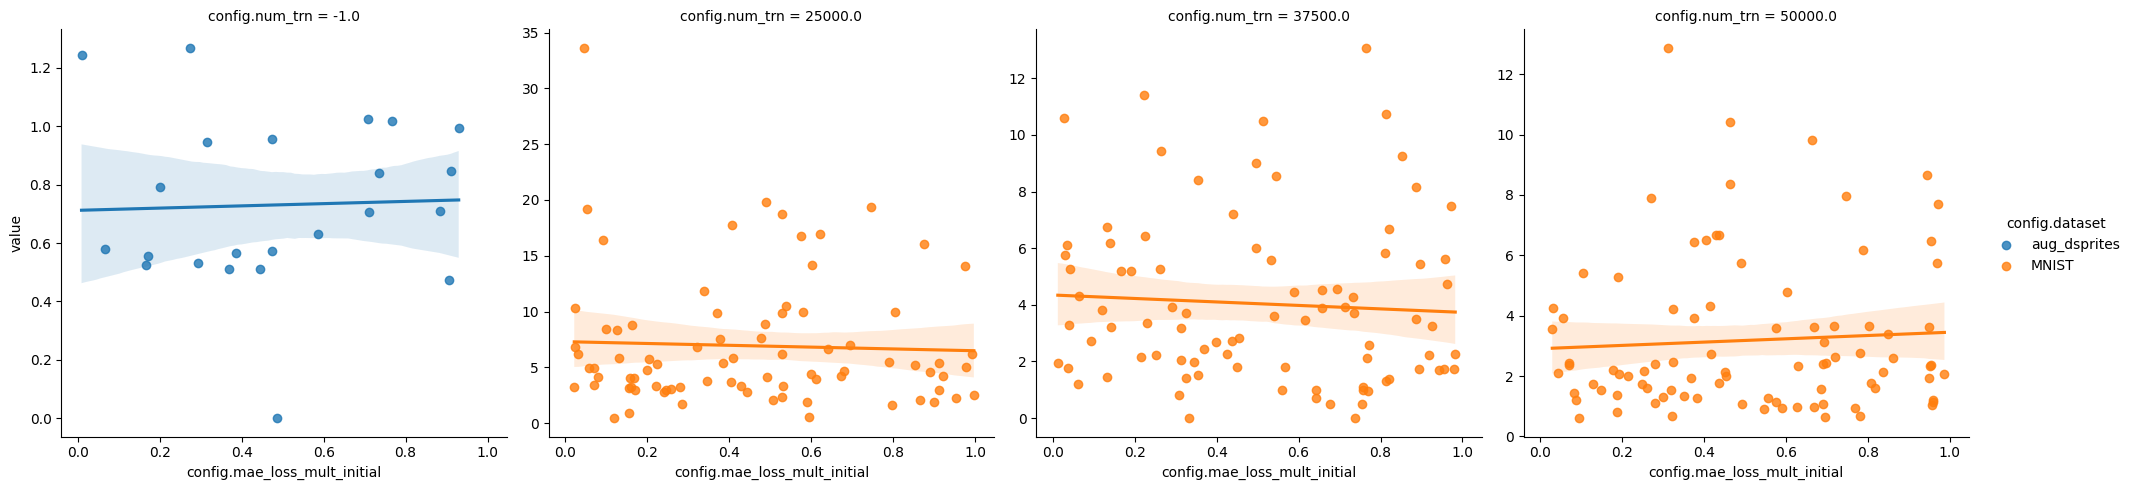

In [187]:
g = sns.lmplot(
    data=df[df.metric == "summary.valid/mae"],
    x="config.mae_loss_mult_initial",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

### model.conditioner.hidden_dims

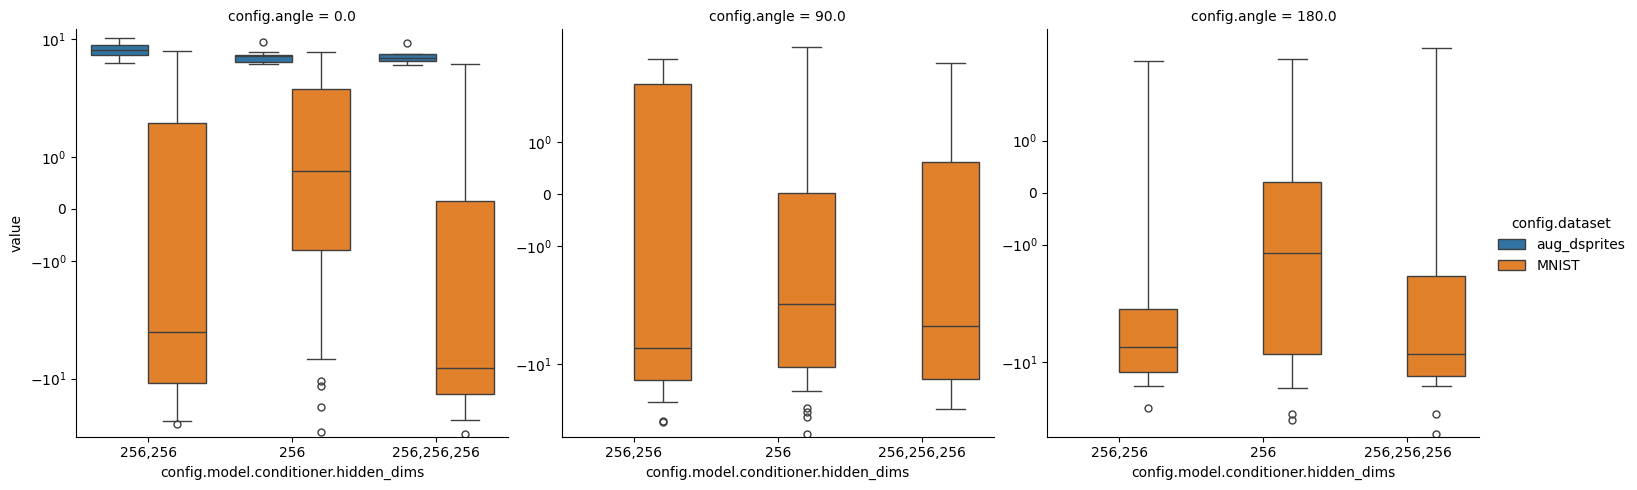

In [154]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.conditioner.hidden_dims",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

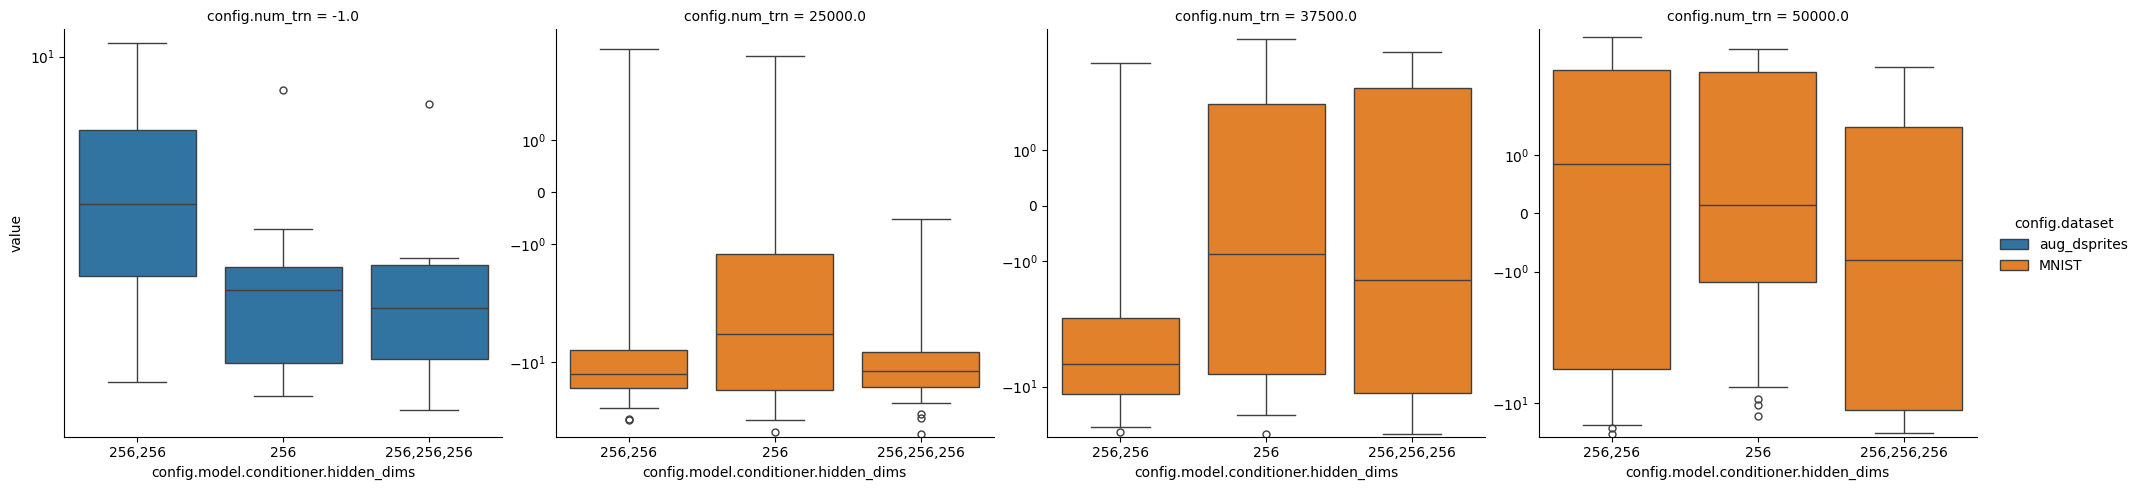

In [155]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.conditioner.hidden_dims",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

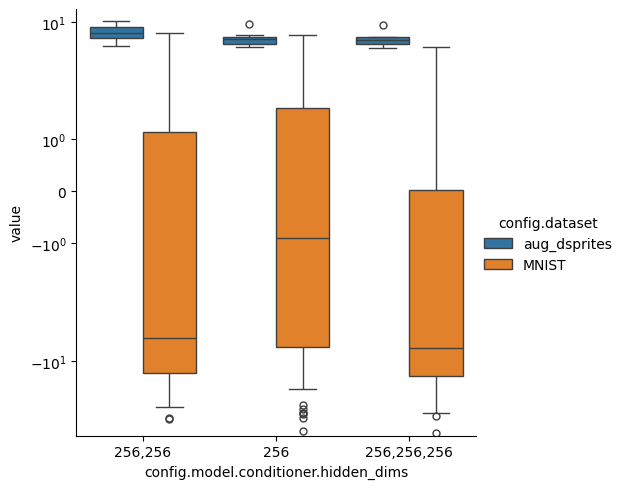

In [156]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.conditioner.hidden_dims",
    y="value",
    hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### model.hidden_dims

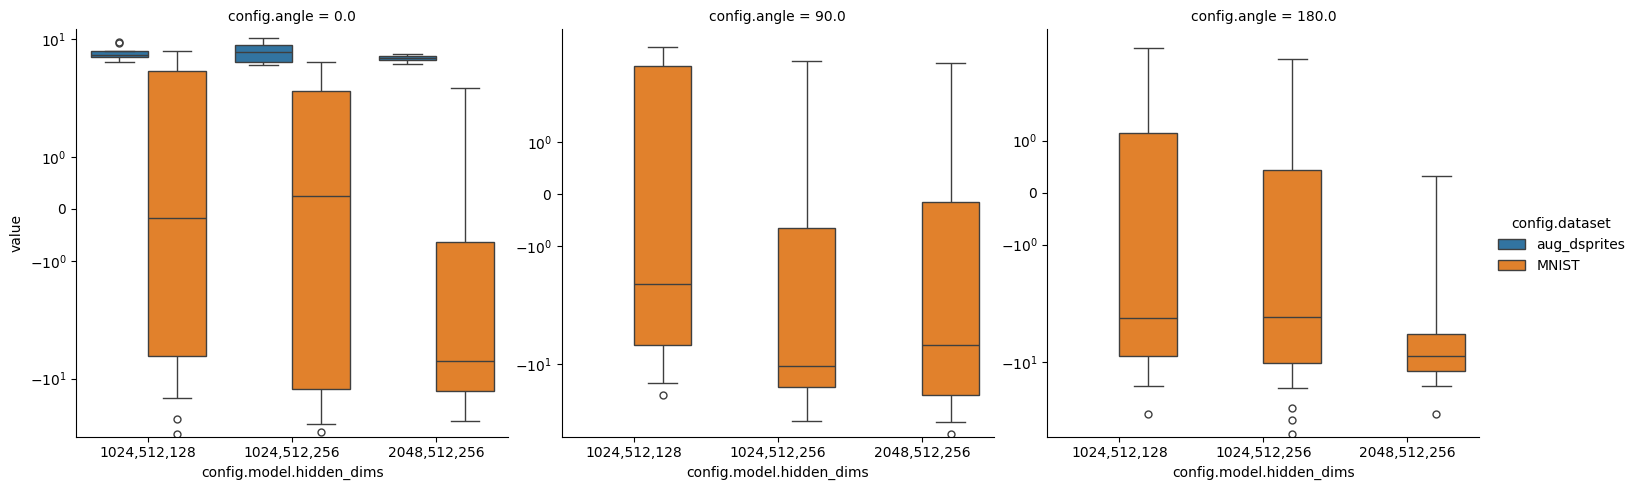

In [157]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.hidden_dims",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

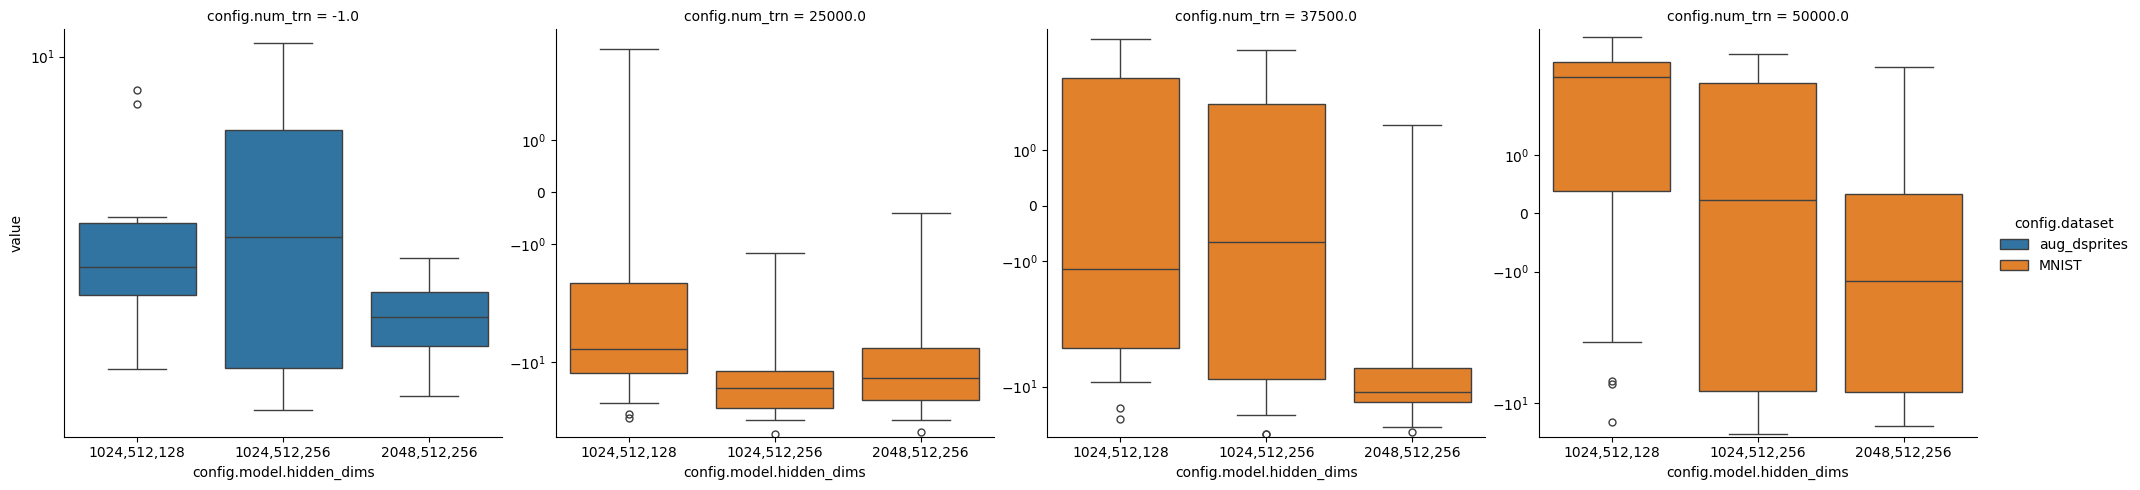

In [158]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.hidden_dims",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

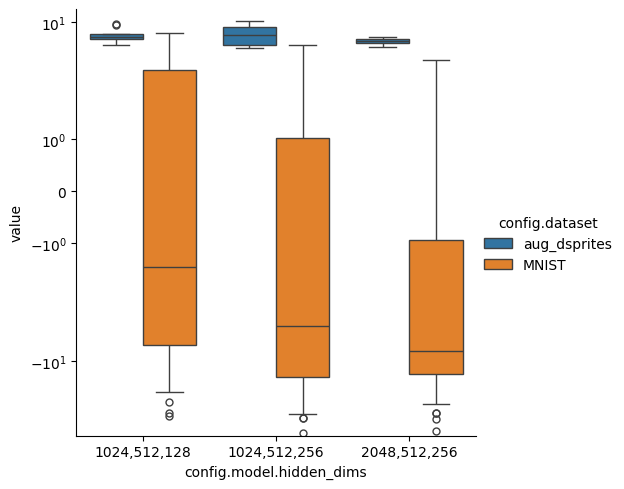

In [159]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.hidden_dims",
    y="value",
    hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### model.num_bins

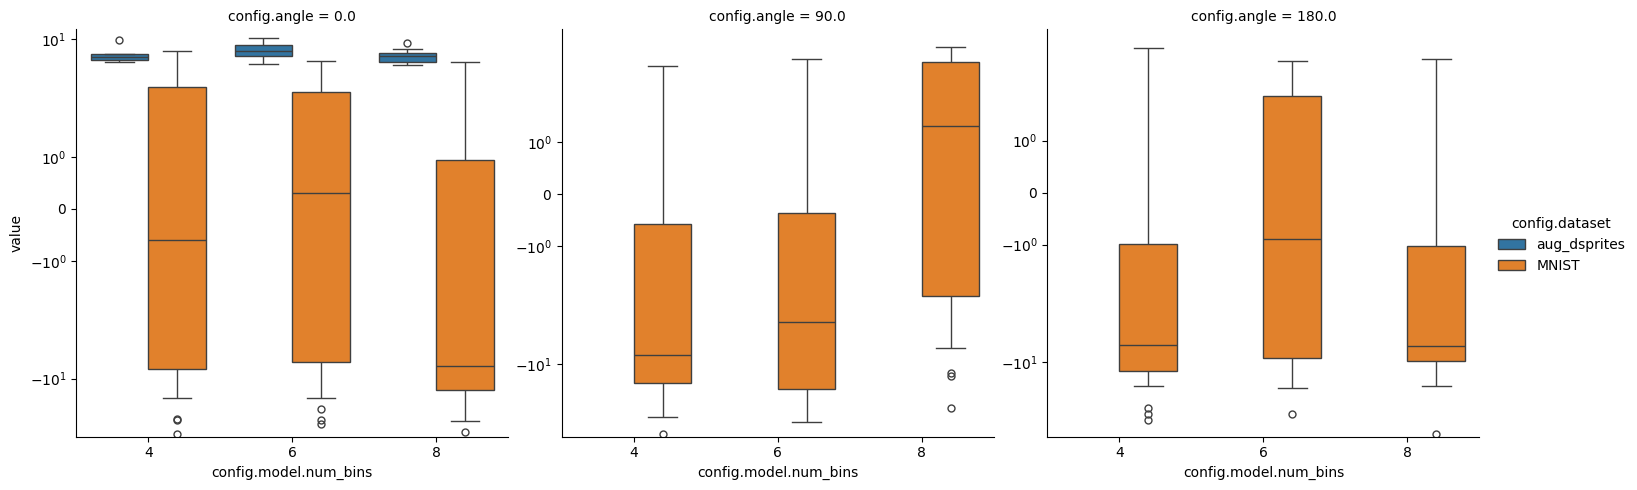

In [160]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_bins",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

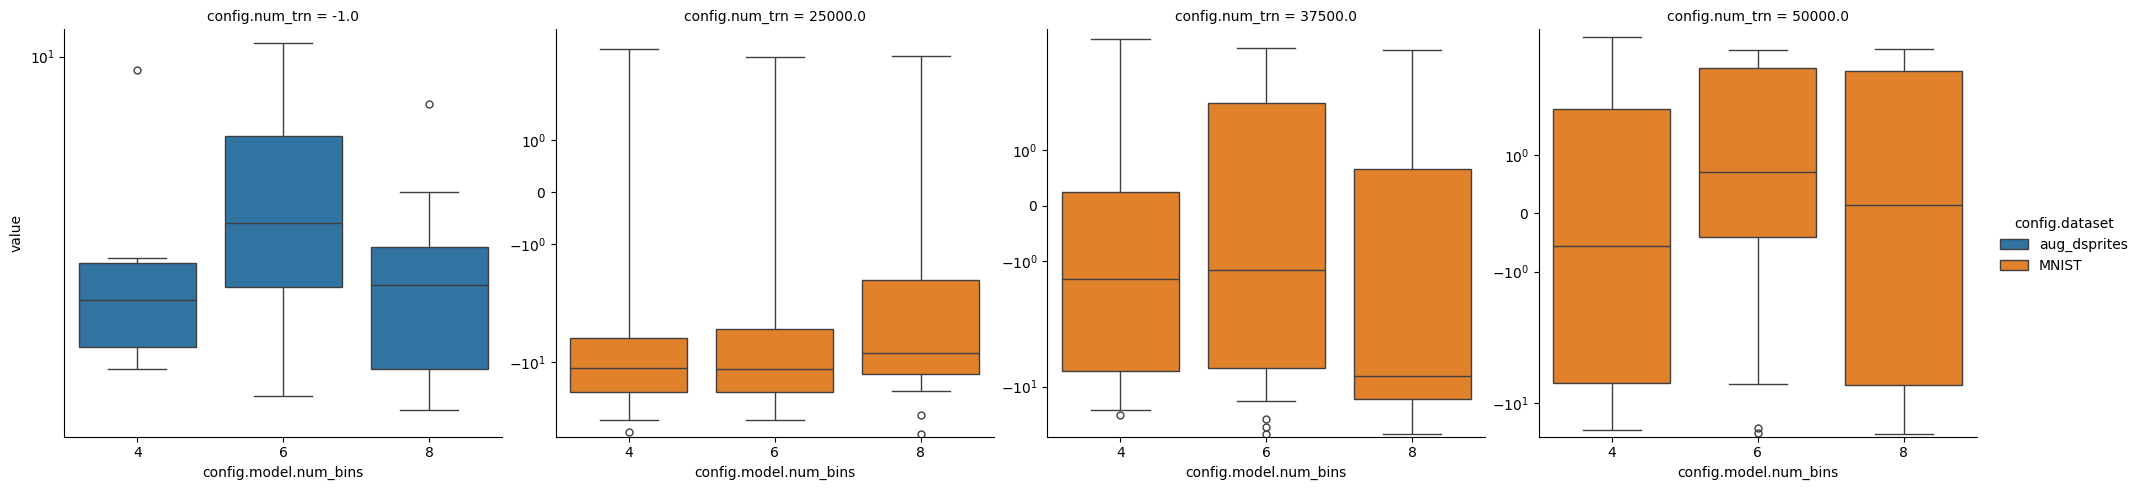

In [161]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_bins",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

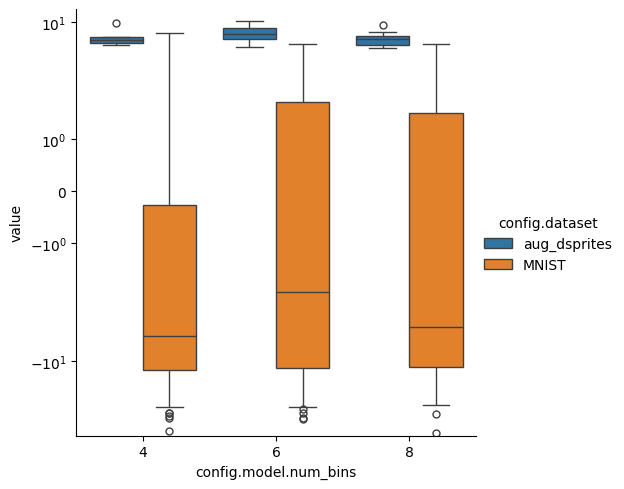

In [162]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_bins",
    y="value",
    hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### model.num_flows

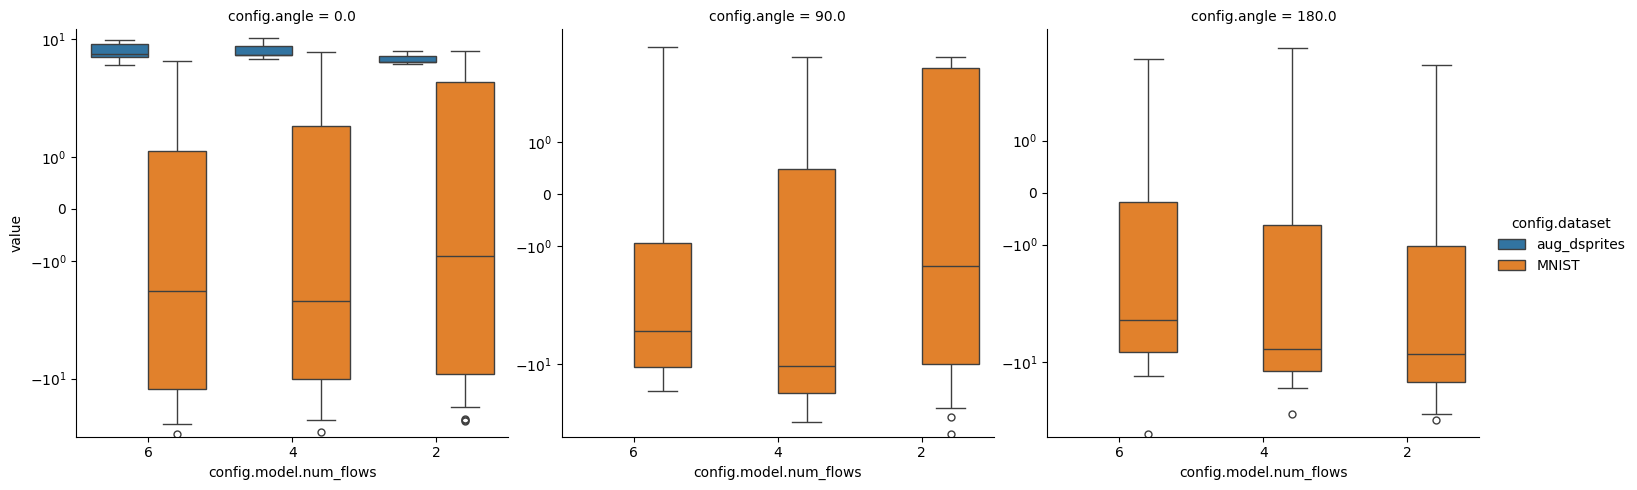

In [163]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_flows",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

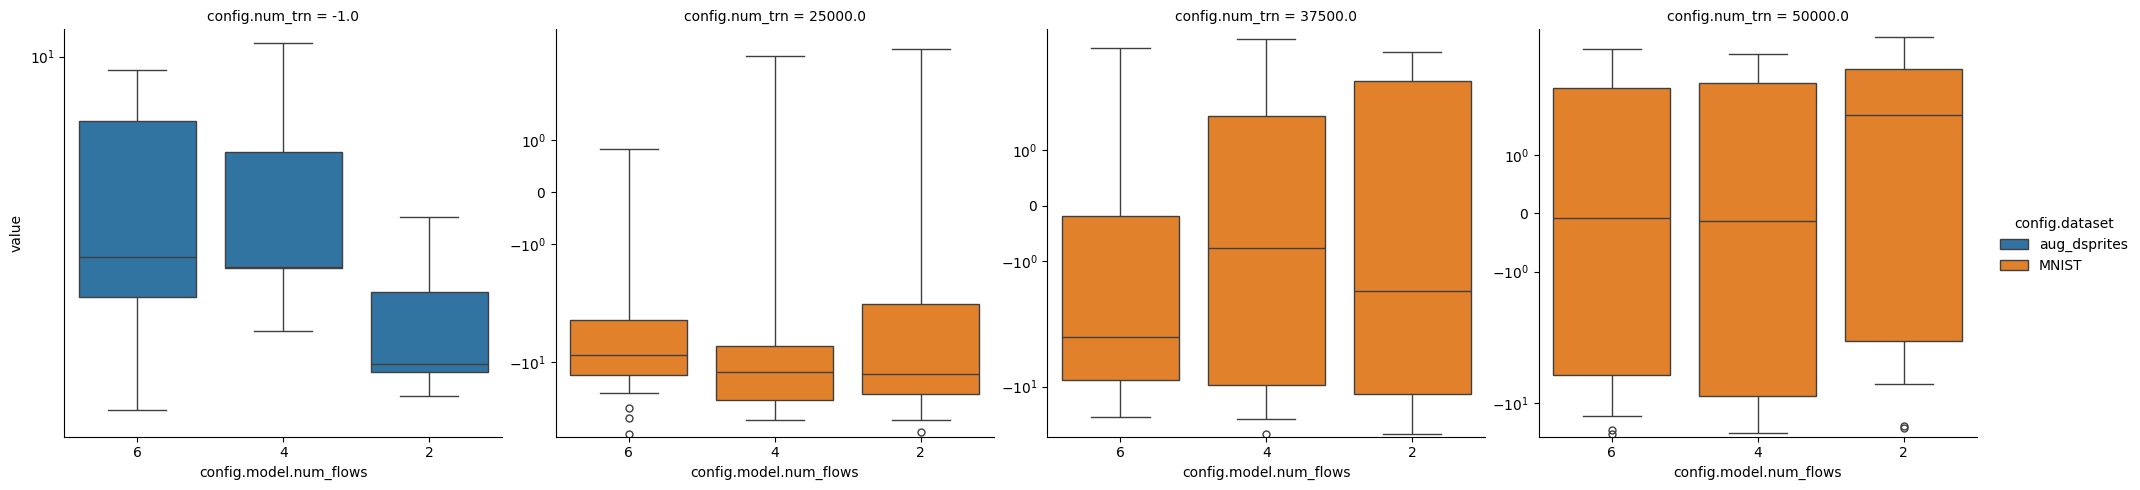

In [164]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_flows",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

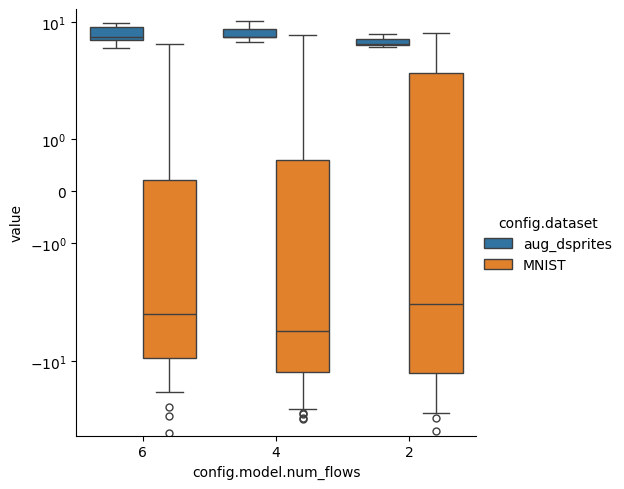

In [165]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_flows",
    y="value",
    hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### model.squash_to_bounds

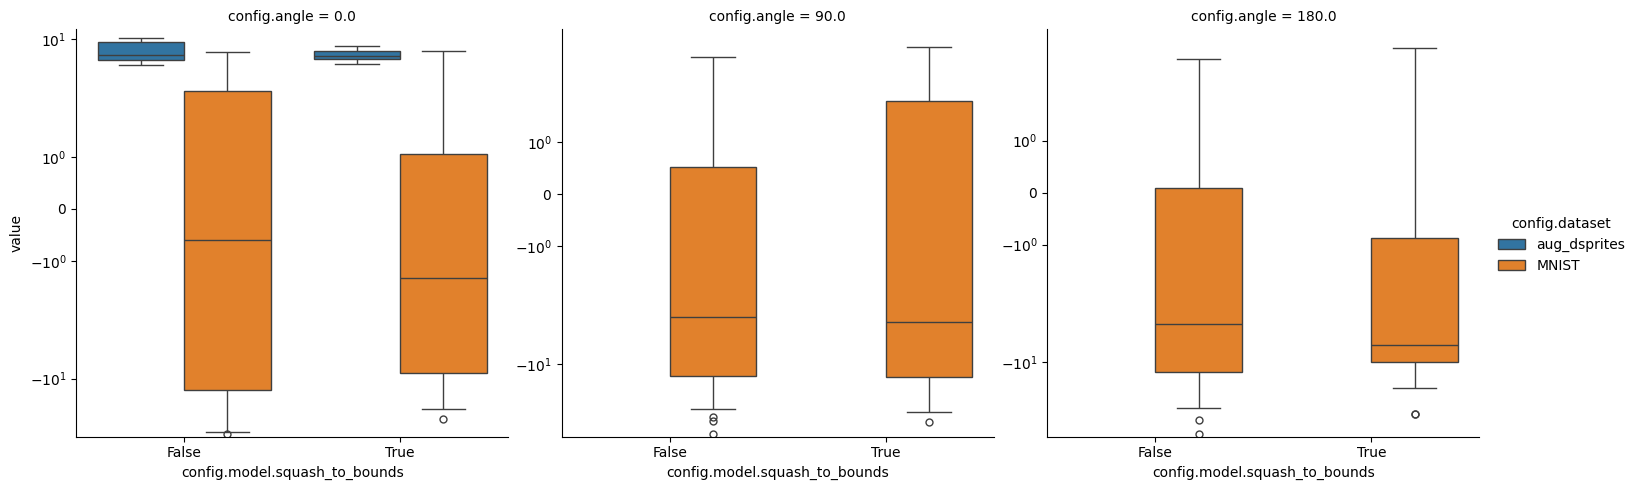

In [166]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.squash_to_bounds",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

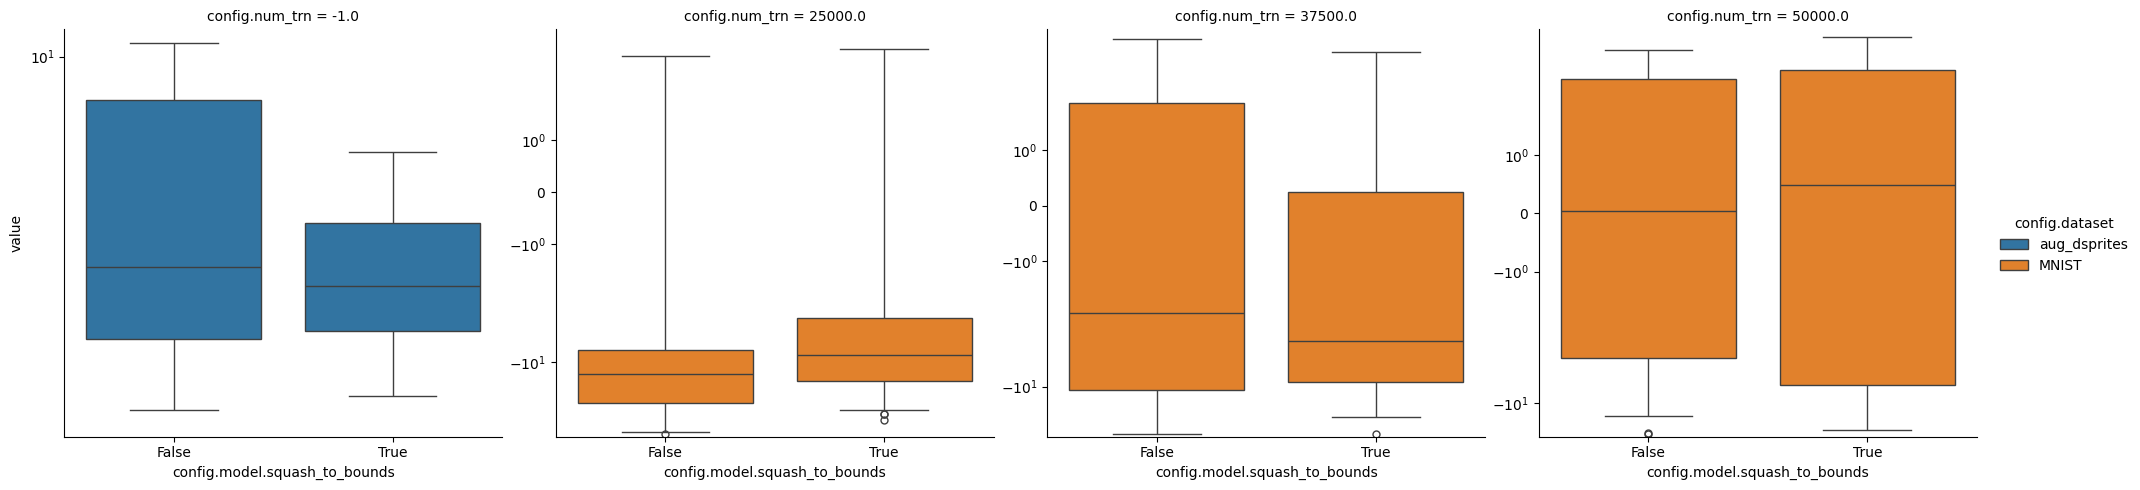

In [167]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.squash_to_bounds",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

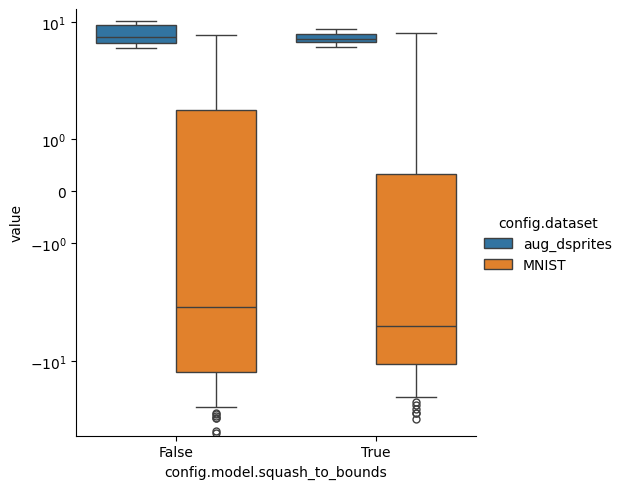

In [168]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.squash_to_bounds",
    y="value",
    hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### model.use_layernorm

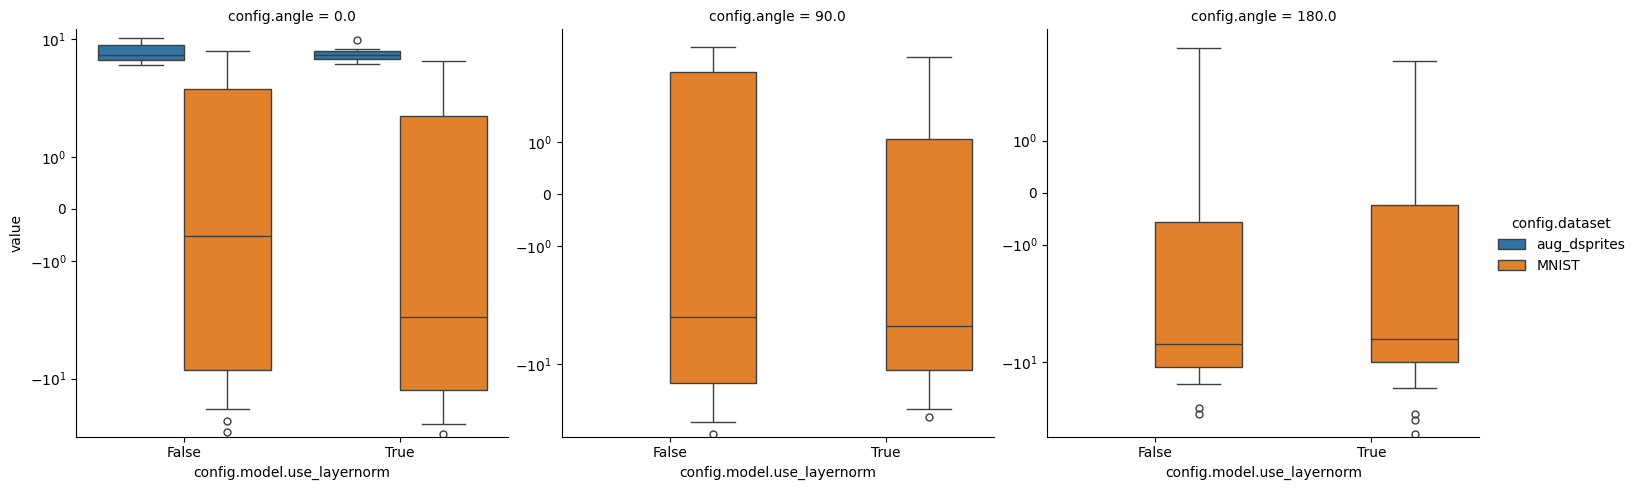

In [169]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.use_layernorm",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

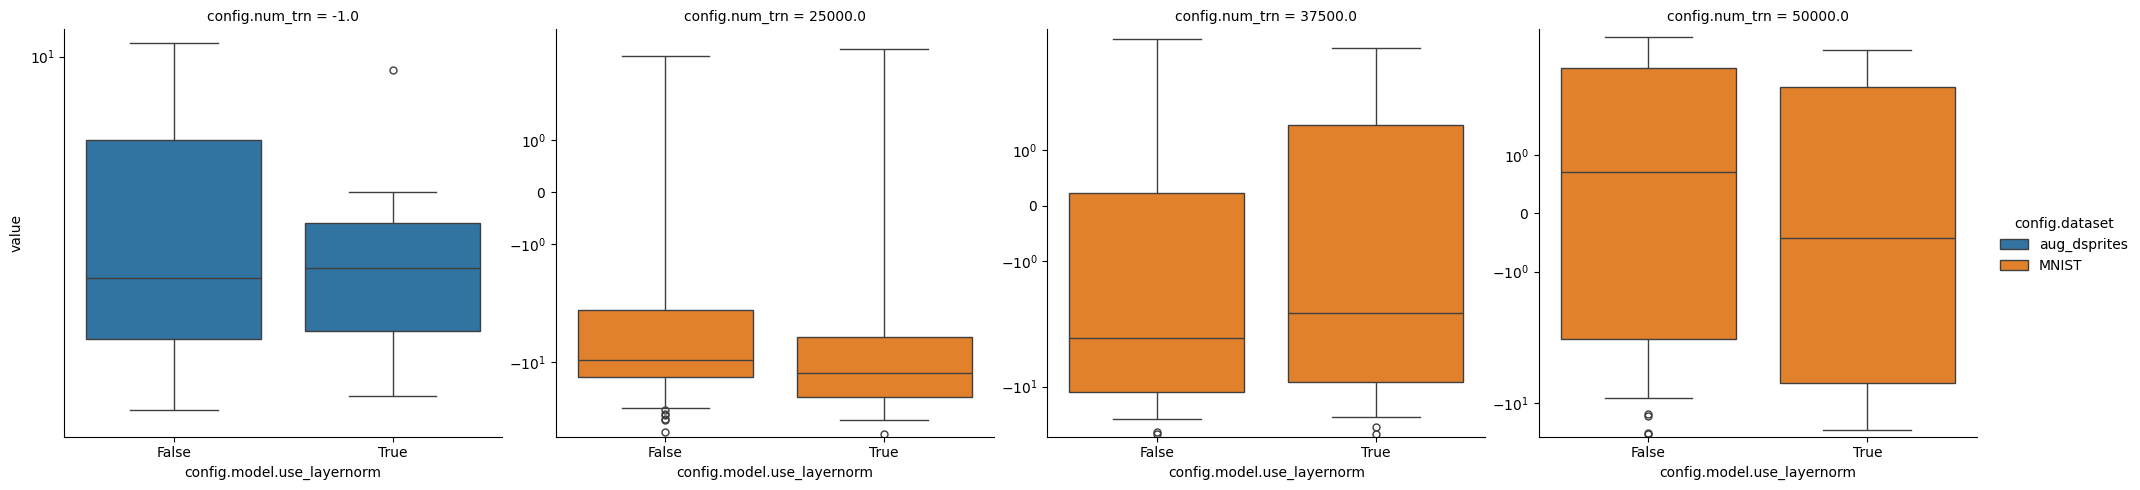

In [170]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.use_layernorm",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

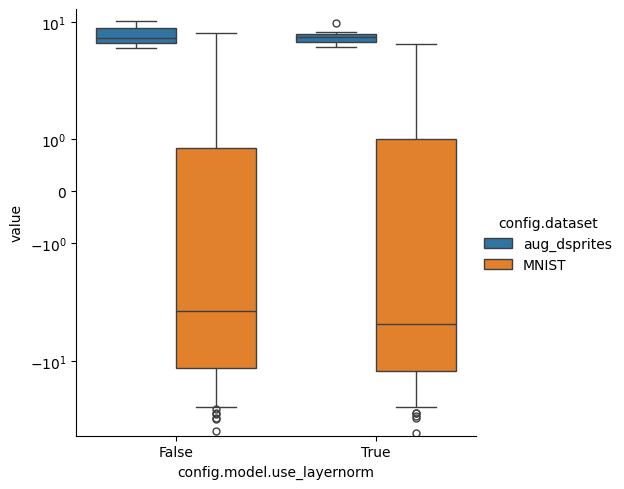

In [171]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.use_layernorm",
    y="value",
    hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### n_samples

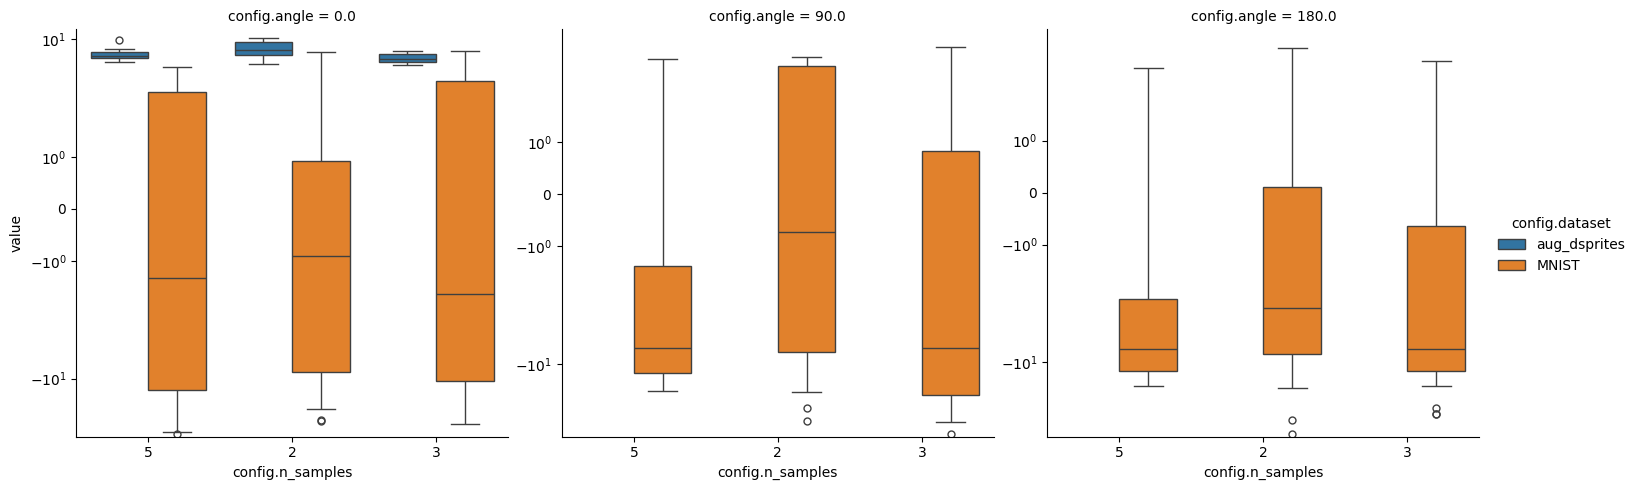

In [172]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.n_samples",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

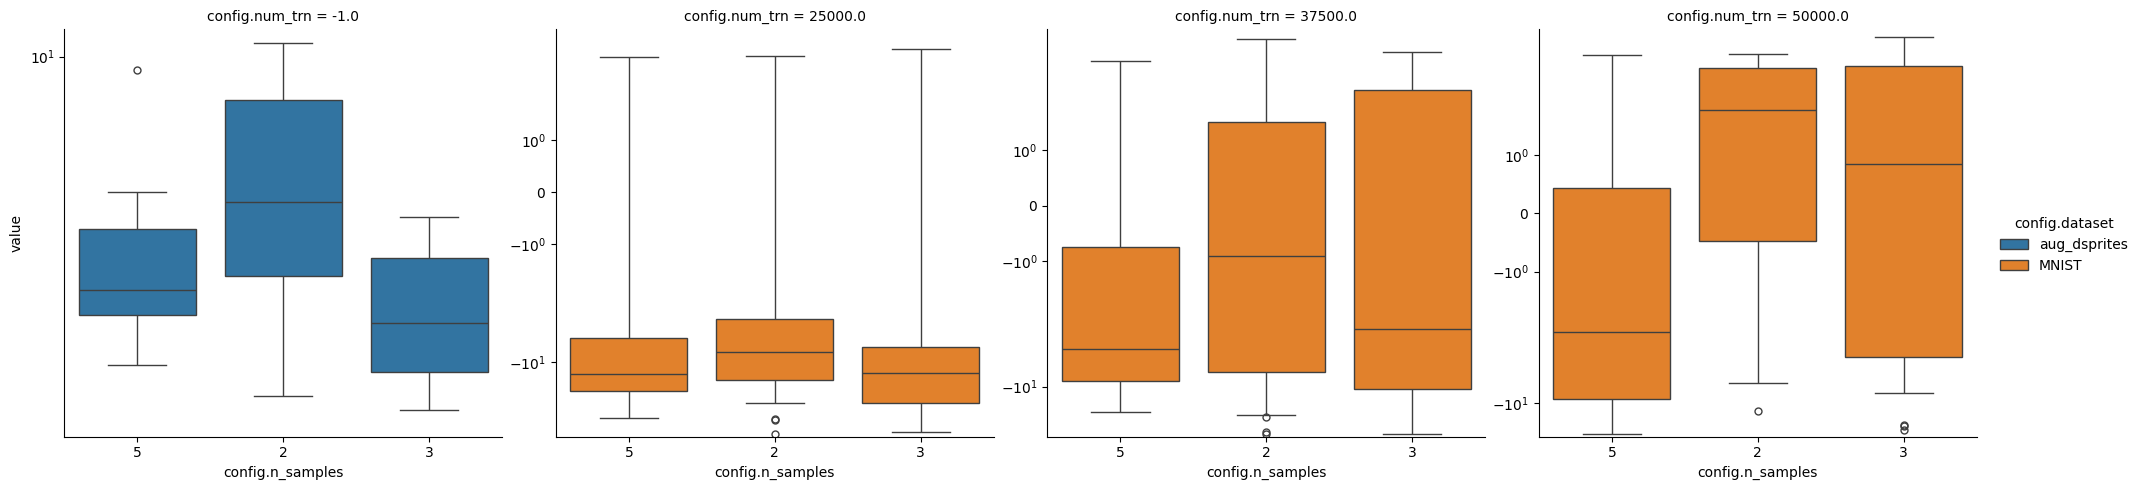

In [173]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.n_samples",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

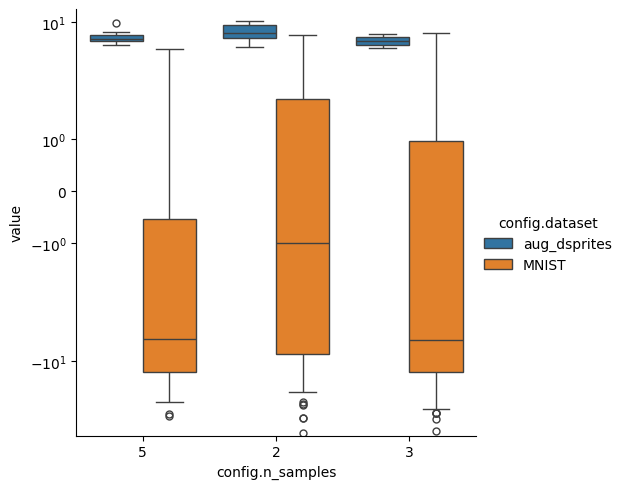

In [174]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.n_samples",
    y="value",
    hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### steps

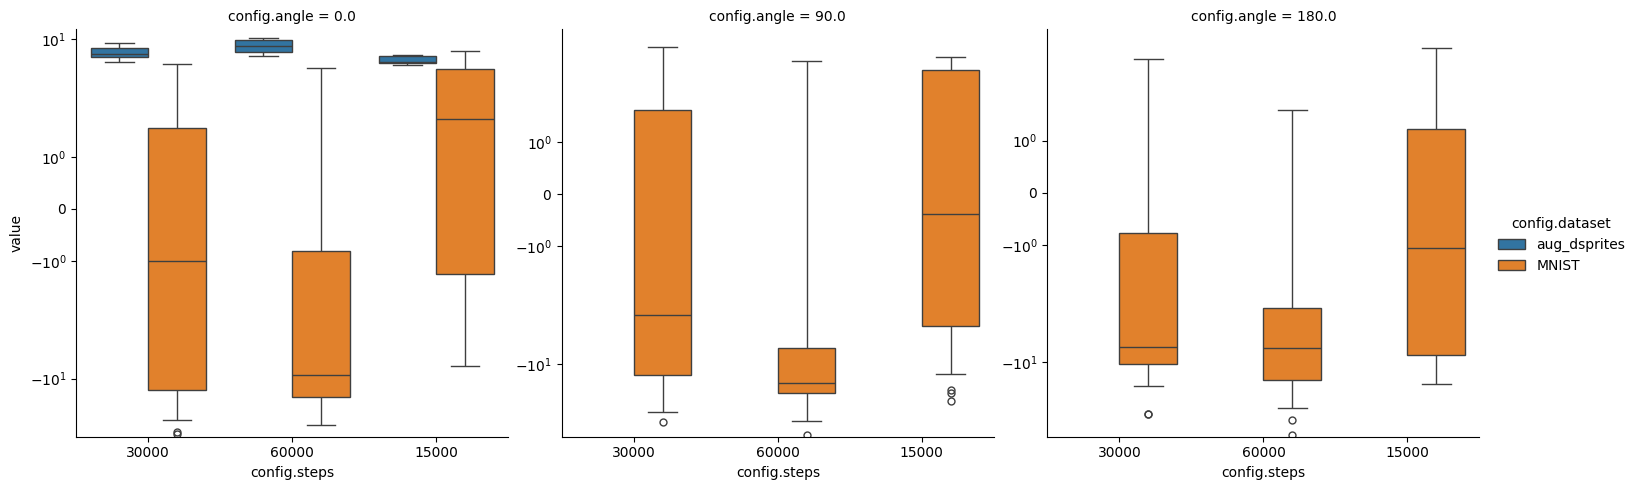

In [175]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.steps",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

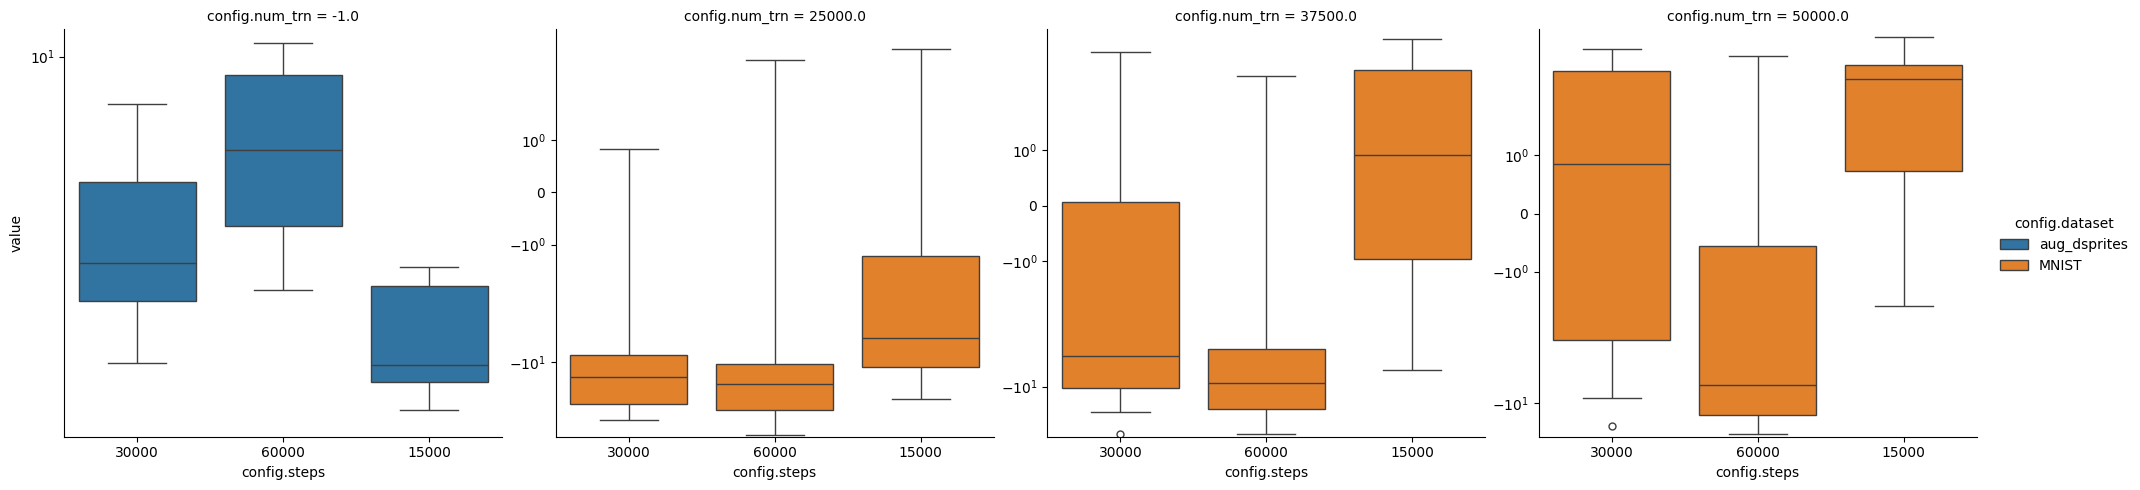

In [176]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.steps",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

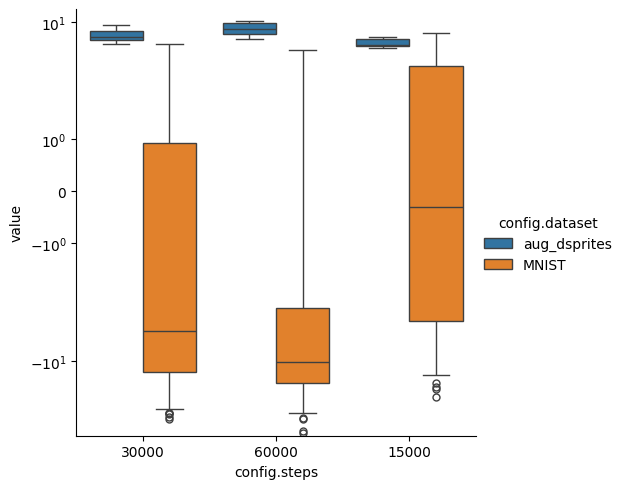

In [177]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.steps",
    y="value",
    hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### warmup_steps_pct

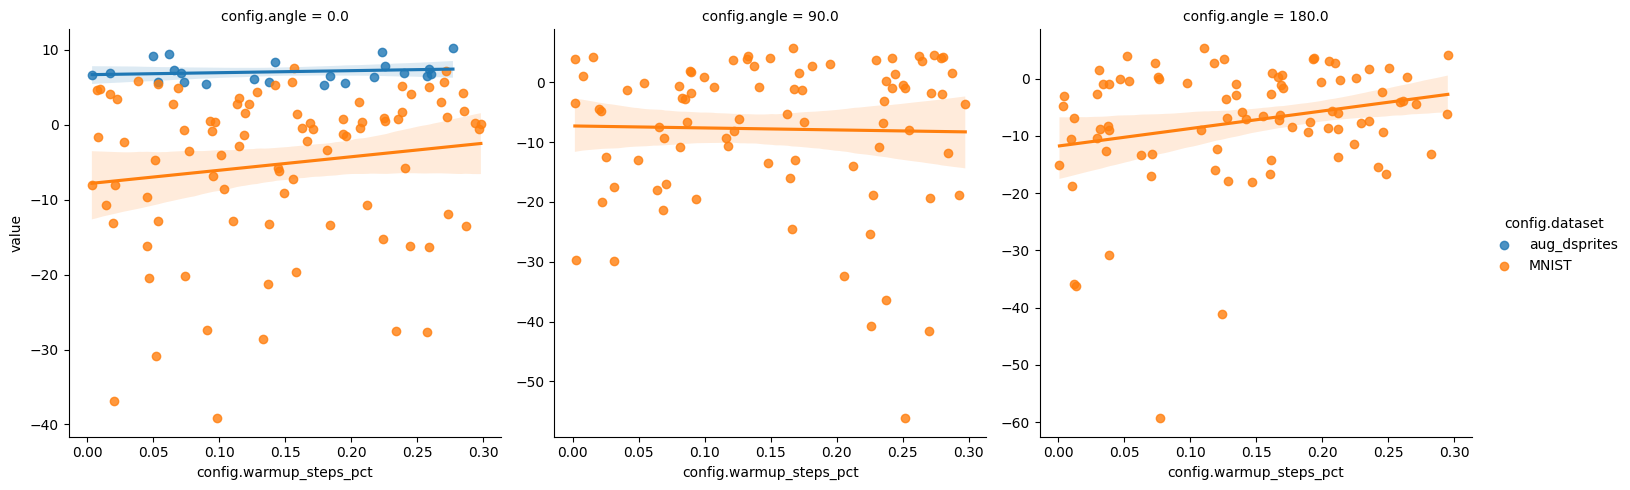

In [178]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.warmup_steps_pct",
    y="value",
    col="config.angle",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

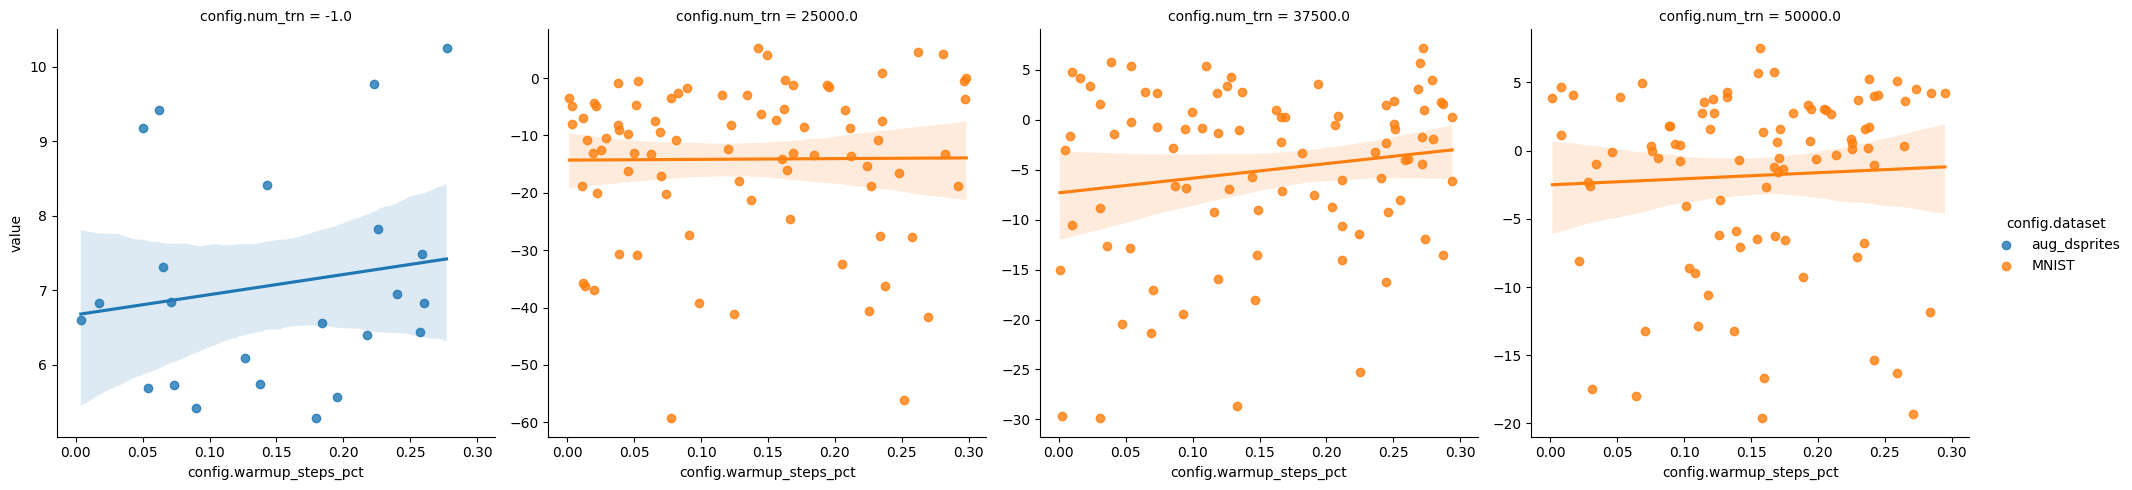

In [179]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.warmup_steps_pct",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

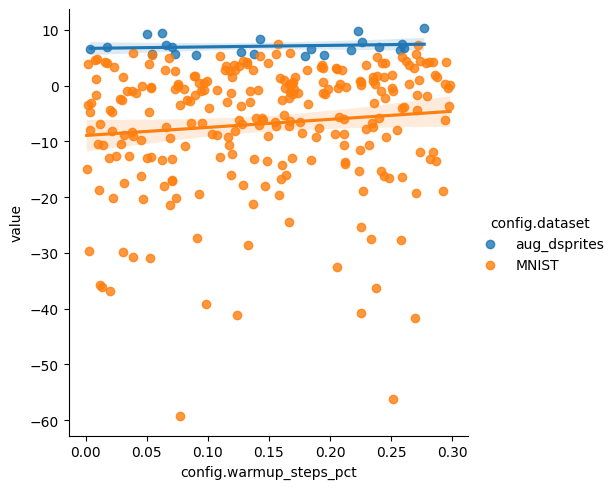

In [180]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.warmup_steps_pct",
    y="value",
    hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

### weight_decay

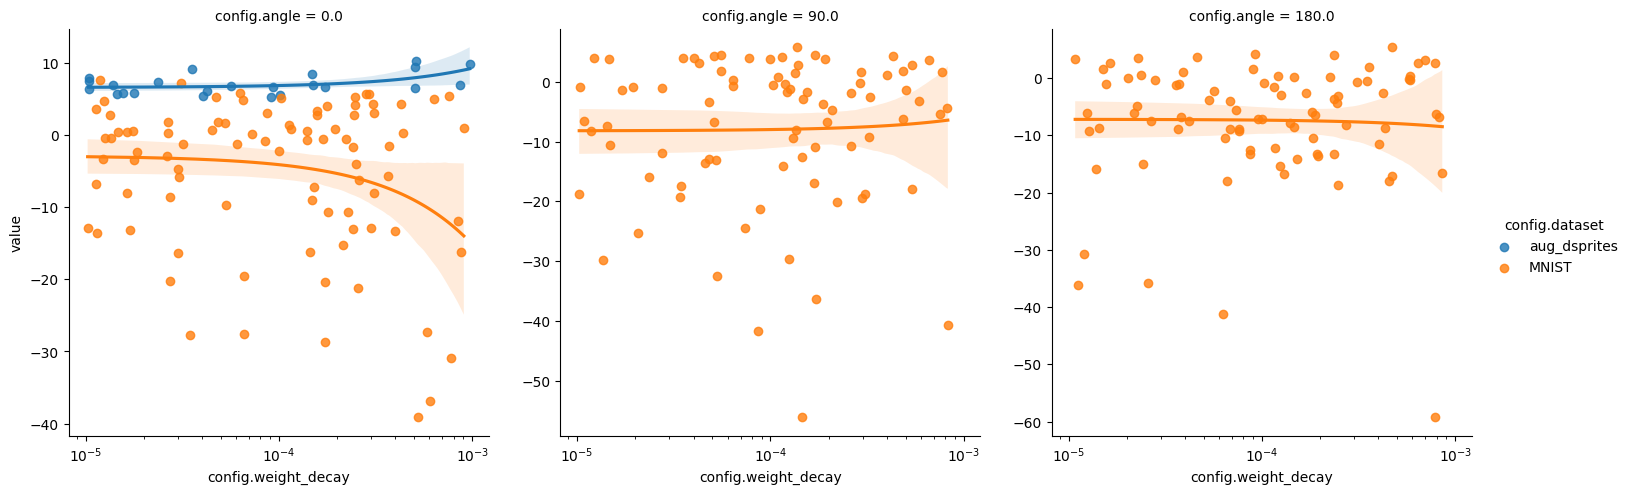

In [181]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.weight_decay",
    y="value",
    col="config.angle",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

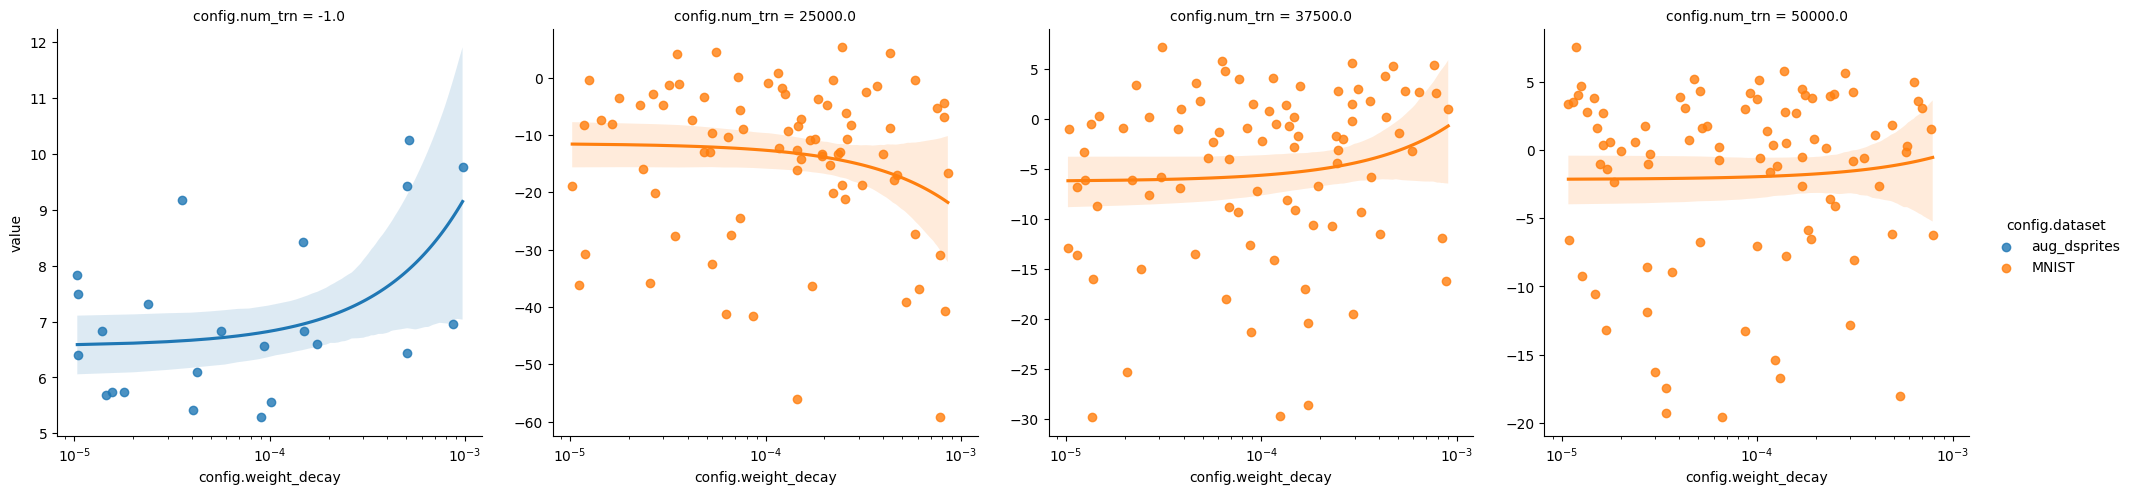

In [182]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.weight_decay",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

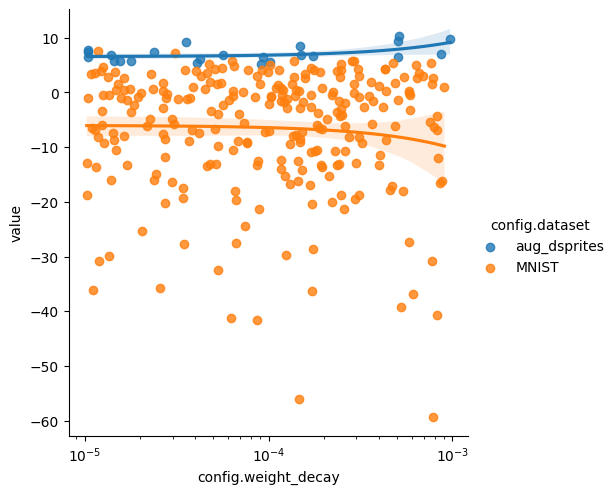

In [183]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.weight_decay",
    y="value",
    hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g